In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:42185")
client

<Client: 'tcp://127.0.0.1:42185' processes=8 threads=40, memory=157.35 GiB>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd

import os.path as op

from xgcm.grid import Grid
import MITgcmutils as mitutils
from xmitgcm import open_mdsdataset

import gcm_filters

import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/tank/chaocean/qjamet/RUNS/ORAR/reruns2/'
tdir = '/tank/chaocean/qjamet/RUNS/ORAR/'
gdir = '/tank/chaocean/grid_chaO/gridMIT_update1/'
savedir = '/tank/spectre/tuchida/NA-wavelets/'
diag = '/tank/spectre/tuchida/diagnostics/'
# tdgs = '/tank/tdgs/tuchida/TWA/'
spec = '/tank/spectre/tuchida/NA-wavelets/'

In [4]:
grav = 9.81
nensembs = 5
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
# Cp = 3.994e3
Cp = 3989.244953
# years = np.arange(2008,2013,dtype=int)
ySstart = -15
yNstart = 15
yend = 50
dnf = 2160
nfile = 73

In [5]:
xs = [295,318,
      297.5,316,
      300,315
     ]
ys = [37,43,
      30.5,30,
      24,22
     ]
reg = 0
sreg = ['A','B','C','D','E','F']

xo = 50e3
ntheta = 36

nmembs = np.arange(100,148)
xchunk = 200
ychunk = 200

In [6]:
# reg = 3
dg = 1
nmembs = np.arange(100,148)

iiter = 1419120
# iiter = 1421280
# iiter = 1423440

dsb = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn'), 
                      grid_dir=gdir,
                      prefix=['snap_diagOcn'], delta_t=2e2,
                      iters=iiter, 
                     ).sel(YC=slice(15-dg/12,50+dg/12),
                           YG=slice(15-dg/12,50+dg/12),
                           XC=slice(273-dg/12,330+dg/12),
                           XG=slice(273-dg/12,330+dg/12)
                          ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1}).isel(time=0)
    
for nmemb in nmembs:
    if nmemb == 100:
        ds = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                     % (nmemb)), 
                             grid_dir=gdir,
                             prefix=['snap_diagOcn'], delta_t=2e2,
                             iters=iiter, 
                            ).sel(YC=slice(15-dg/12,50+dg/12),
                                  YG=slice(15-dg/12,50+dg/12),
                                  XC=slice(273-dg/12,330+dg/12),
                                  XG=slice(273-dg/12,330+dg/12)
                                 ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1}).isel(time=0)
    else:
        ds = xr.concat([ds, open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                                    % (nmemb)), 
                                            grid_dir=gdir,
                                            prefix=['snap_diagOcn'], delta_t=2e2,
                                            iters=iiter, 
                                           ).sel(YC=slice(15-dg/12,50+dg/12),
                                                 YG=slice(15-dg/12,50+dg/12),
                                                 XC=slice(273-dg/12,330+dg/12),
                                                 XG=slice(273-dg/12,330+dg/12)
                                                ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1}
                                                       ).isel(time=0)
                       ], dim='nmemb')

if len(dsb.XG) > len(dsb.XC):
     dsb = dsb.isel(XG=slice(None,-1))
elif len(dsb.XG) < len(dsb.XC):
     dsb = dsb.isel(XC=slice(1,None))  
if len(ds.XG) > len(ds.XC):
     ds = ds.isel(XG=slice(None,-1))
elif len(ds.XG) < len(ds.XC):
     ds = ds.isel(XC=slice(1,None))  
# if len(dsb.YG) > len(dsb.YC):
#      dsb = dsb.isel(YG=slice(None,-1))
# if len(ds.YG) > len(ds.YC):
#      ds = ds.isel(YG=slice(None,-1))
        
ds.coords['nmemb'] = ('nmemb',nmembs)

ub = dsb.UVEL
vb = dsb.VVEL
u = ds.UVEL
v = ds.VVEL
up = u - ub
vp = v - vb

grid = Grid(ds, periodic=[])
coords={'X':{'center':'XC', 'left':'XG'}, 
        'Y':{'center':'YC', 'left':'YG'}}
gridz = Grid(ds.isel(Z=[0,18],Zu=[0,18],Zl=[0,18]), 
             periodic=[], coords=coords)
ds

<xarray.Dataset>
Dimensions:  (XC: 664, YC: 422, XG: 664, YG: 422, Z: 46, Zp1: 47, Zu: 46,
              Zl: 46, nmemb: 48)
Coordinates: (12/34)
    iter     int64 dask.array<chunksize=(), meta=np.ndarray>
    time     timedelta64[ns] 3285 days
  * XC       (XC) >f4 273.0 273.1 273.2 273.3 273.4 ... 329.8 329.9 330.0 330.1
  * YC       (YC) >f4 14.92 15.0 15.08 15.17 15.25 ... 49.75 49.83 49.92 50.0
  * XG       (XG) >f4 273.0 273.1 273.1 273.2 273.3 ... 329.8 329.9 329.9 330.0
  * YG       (YG) >f4 14.96 15.04 15.13 15.21 15.29 ... 49.79 49.88 49.96 50.04
    ...       ...
    maskS    (Z, YG, XC) bool dask.array<chunksize=(1, 422, 664), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.array<chunksize=(422, 664), meta=np.ndarray>
    rhoRef   (Z) >f4 dask.array<chunksize=(1,), meta=np.ndarray>
    maskInW  (YC, XG) bool dask.array<chunksize=(422, 664), meta=np.ndarray>
    maskInS  (YG, XC) bool dask.array<chunksize=(422, 664), meta=np.ndarray>
  * nmemb    (nmemb) int64 100 101 102 103 104 105 ... 142 143 144 145 146 147
Data variables:
    THETA    (nmemb, Z, YC, XC) float32 dask.array<chunksize=(1, 1, 422, 664), meta=np.ndarray>
    SALT     (nmemb, Z, YC, XC) float32 dask.array<chunksize=(1, 1, 422, 664), meta=np.ndarray>
    UVEL     (nmemb, Z, YC, XG) float32 dask.array<chunksize=(1, 1, 422, 664), meta=np.ndarray>
    VVEL     (nmemb, Z, YG, XC) float32 dask.array<chunksize=(1, 1, 422, 664), meta=np.ndarray>
    WVEL     (nmemb, Zl, YC, XC) float32 dask.array<chunksize=(1, 1, 422, 664), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir='/tank/chaocea...

In [8]:
# grid info centered at T-points
wet_mask_t = ds.maskC.isel(Z=[0,18])
wet_mask_t[dict(XC=-1)] = 0.
wet_mask_t[dict(XC=0)] = 0.
wet_mask_t[dict(YC=-1)] = 0.
wet_mask_t[dict(YC=0)] = 0.

# grid info centered at vorticity points
wet_mask_q = grid.interp(ds.maskW, 'Y', boundary='extend'
                        ).isel(Z=[0,18]).swap_dims({"XG": "XC", "YG": "YC"})
wet_mask_q[dict(XC=-1)] = 0.
wet_mask_q[dict(XC=0)] = 0.
wet_mask_q[dict(YC=-1)] = 0.
wet_mask_q[dict(YC=0)] = 0.

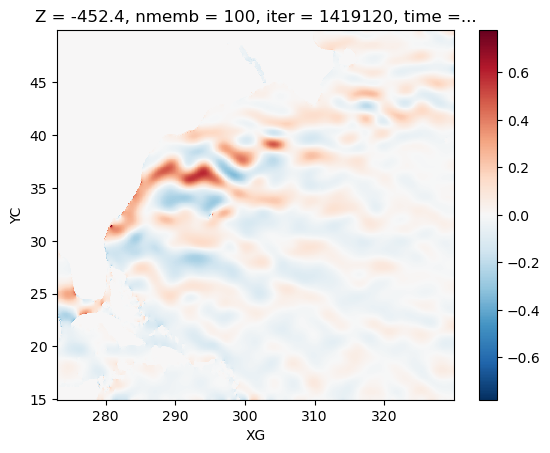

200000.0


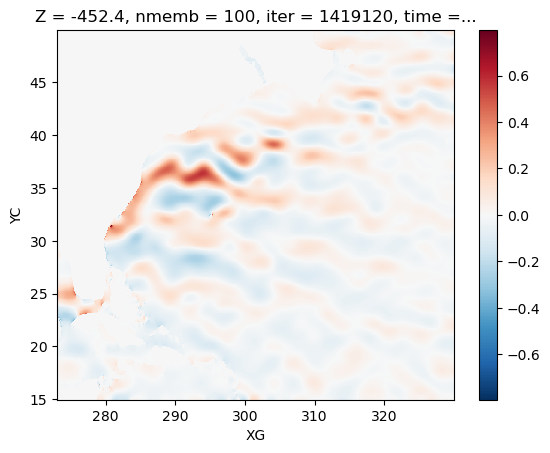

210000.0


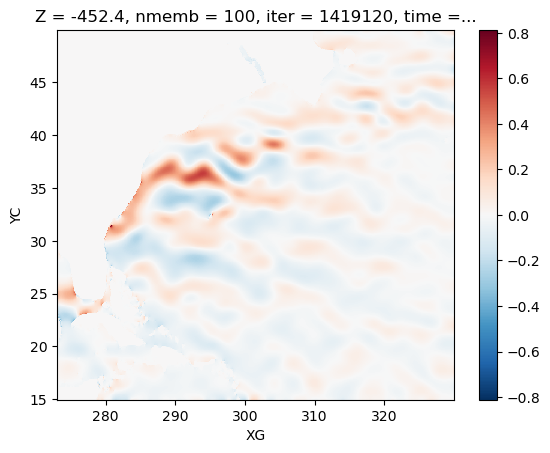

220000.0


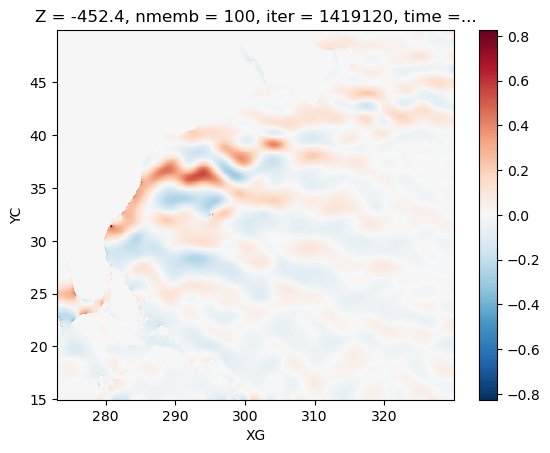

230000.0


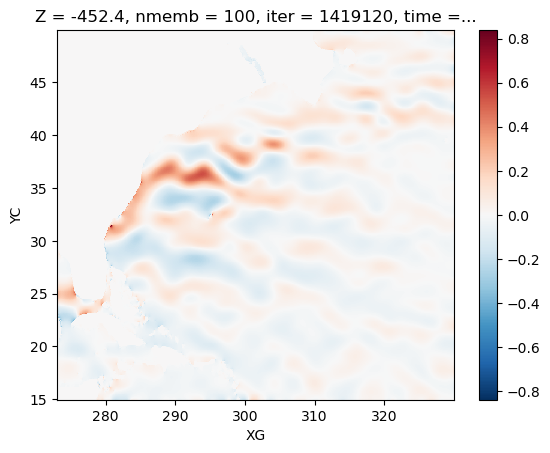

240000.0


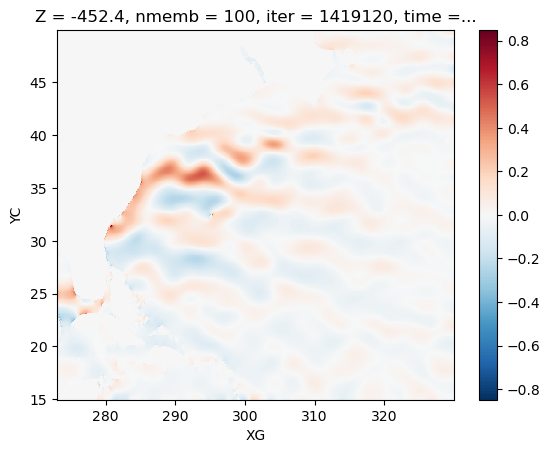

250000.0


In [9]:
dxT = grid.interp(ds.dxG, 'Y', boundary='extend')
dyT = grid.interp(ds.dyG, 'X', boundary='extend')
# grid info centered at U-points
dxCu = ds.dxC.swap_dims({"XG": "XC"})
dyCu = ds.dyG.swap_dims({"XG": "XC"})
area_u = dxCu * dyCu
# grid info centered at V-points
dxCv = ds.dxG.swap_dims({"YG": "YC"})
dyCv = ds.dyC.swap_dims({"YG": "YC"})
area_v = dxCv * dyCv

dxBu = grid.interp(ds.dxC,'Y',boundary='extend').swap_dims({"XG": "XC", "YG": "YC"})
dyBu = grid.interp(ds.dyC,'X',boundary='extend').swap_dims({"XG": "XC", "YG": "YC"})

dx_min = min(dxT.where(wet_mask_t).min(), dyT.where(wet_mask_t).min())
dx_min = dx_min.values

# dx_max = max(dxT.max(), dyT.max(), dxCu.max(), dyCu.max(), 
#              dxCv.max(), dyCv.max(), dxBu.max(), dyBu.max())
# dx_max = dx_max.values

kappa_iso = xr.ones_like(dxT)
kappa_aniso = xr.zeros_like(dyT)

for filter_scale in np.arange(200e3,260e3,10e3):
    
    filter_visc = gcm_filters.Filter(
        filter_scale=filter_scale,
        dx_min=dx_min,
        filter_shape=gcm_filters.FilterShape.GAUSSIAN,
        grid_type=gcm_filters.GridType.VECTOR_C_GRID,
        grid_vars={
            'wet_mask_t': wet_mask_t, 'wet_mask_q': wet_mask_q,
            'dxT': dxT, 'dyT': dyT, 
            'dxCu': dxCu, 'dyCu': dyCu, 'area_u': area_u, 
            'dxCv': dxCv, 'dyCv': dyCv, 'area_v': area_v,
            'dxBu': dxBu, 'dyBu': dyBu,
            'kappa_iso': kappa_iso, 'kappa_aniso': kappa_aniso
        }
    )
    
    # U  = u.swap_dims({'XG':'XC'}).reset_coords(drop=True)
    # V  = v.swap_dims({'YG':'YC'}).reset_coords(drop=True)
    ds_tmp = xr.Dataset()  # temporary dataset with swapped dimensions
    ds_tmp['u'] = u.isel(Z=[0,18])
    ds_tmp['v'] = v.isel(Z=[0,18])
    ds_tmp['u'] = ds_tmp['u'].swap_dims({'XG':'XC'})
    ds_tmp['v'] = ds_tmp['v'].swap_dims({'YG':'YC'})
    (u_filtered, v_filtered) = filter_visc.apply_to_vector(ds_tmp.u, ds_tmp.v, 
                                                           dims=['YC', 'XC'])
    u_filtered = u_filtered.swap_dims({"XC":"XG"}).isel(XG=slice(1,-1),YC=slice(1,-1))
    v_filtered = v_filtered.swap_dims({"YC":"YG"}).isel(YG=slice(1,-1),XC=slice(1,-1))
    ds_tmp.close()
    
    u_filtered.isel(nmemb=0,Z=1).plot(rasterized=True)
    plt.show()
    # Ub = ub.swap_dims({'XG':'XC'}).reset_coords(drop=True)
    # Vb = vb.swap_dims({'YG':'YC'}).reset_coords(drop=True)
    ds_tmp = xr.Dataset()  # temporary dataset with swapped dimensions
    ds_tmp['U'] = ub.isel(Z=[0,18])
    ds_tmp['V'] = vb.isel(Z=[0,18])
    ds_tmp['U'] = ds_tmp['U'].swap_dims({'XG':'XC'})
    ds_tmp['V'] = ds_tmp['V'].swap_dims({'YG':'YC'})
    (U_filtered, V_filtered) = filter_visc.apply_to_vector(ds_tmp.U, ds_tmp.V, 
                                                           dims=['YC', 'XC'])
    ub_filtered = U_filtered.swap_dims({"XC":"XG"})
    vb_filtered = V_filtered.swap_dims({"YC":"YG"})
    ds_tmp.close()
    # Up = up.swap_dims({'XG':'XC'})
    # Vp = vp.swap_dims({'YG':'YC'})
    
    
    dsave = u_filtered.reset_coords(drop=True).to_dataset(name="u")
    dsave.chunk({'YC':ychunk,'XG':xchunk}
               ).to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/u.zarr' 
                                 % (iiter,int(filter_scale*1e-3))
                                ), mode='w')
    dsave.close()
    dsave = v_filtered.reset_coords(drop=True).to_dataset(name='v')
    dsave.chunk({'YG':ychunk,'XC':xchunk}
               ).to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/v.zarr' 
                                 % (iiter,int(filter_scale*1e-3))
                                ), mode='w')
    dsave.close()
    dsave = ub_filtered.to_dataset(name='U')
    dsave["V"] = vb_filtered
    dsave.chunk({'YG':ychunk,'YC':ychunk,
                 'XG':xchunk,'XC':xchunk}
               ).to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/U-V.zarr' 
                                 % (iiter,int(filter_scale*1e-3))
                                ), mode='w')
    dsave.close()
    print(filter_scale)

In [10]:
area = ds.rA

dxw = xr.DataArray(
    data=ds.dxC, 
    coords={'YC':ds.YC,'XC':ds.XC}, 
    dims=('YC','XC')
)
dyw = xr.DataArray(
    data=ds.dyG, 
    coords={'YC':ds.YC,'XC':ds.XC}, 
    dims=('YC','XC')
)
dxs = xr.DataArray(
    data=ds.dxG, 
    coords={'YC':ds.YC,'XC':ds.XC}, 
    dims=('YC','XC')
)
dys = xr.DataArray(
    data=ds.dyC, 
    coords={'YC':ds.YC,'XC':ds.XC}, 
    dims=('YC','XC')
)

dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min())
dx_min = dx_min.values

kappa_w = xr.ones_like(dxw)
kappa_s = xr.ones_like(dxw)

for filter_scale in np.arange(30e3,260e3,10e3):
    
    filter_ = gcm_filters.Filter(
        filter_scale=filter_scale,
        dx_min=dx_min,
        filter_shape=gcm_filters.FilterShape.TAPER,
        grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
        grid_vars={
            'wet_mask': wet_mask_t, 
            'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
            'kappa_w': kappa_w, 'kappa_s': kappa_s
        }
    )
    
    uup = grid.interp(u*up,'X',boundary='extend'
                     ).isel(Z=[0,18]).reset_coords(drop=True)
    uup_filtered = filter_.apply(uup, dims=['YC', 'XC']
                                ).isel(YC=slice(1,-1),XC=slice(1,-1))
    
    uvp = (grid.interp(u,'X',boundary='extend') 
           * grid.interp(vp,'Y',boundary='extend')
          ).isel(Z=[0,18]).reset_coords(drop=True)
    uvp_filtered = filter_.apply(uvp, dims=['YC', 'XC']
                                ).isel(YC=slice(1,-1),XC=slice(1,-1))
    
    vup = (grid.interp(up,'X',boundary='extend') 
           * grid.interp(v,'Y',boundary='extend')
          ).isel(Z=[0,18]).reset_coords(drop=True)
    vup_filtered = filter_.apply(vup, dims=['YC', 'XC']
                                ).isel(YC=slice(1,-1),XC=slice(1,-1))
    
    vvp = grid.interp(v*vp,'Y',boundary='extend'
                     ).isel(Z=[0,18]).reset_coords(drop=True)
    vvp_filtered = filter_.apply(vvp, dims=['YC', 'XC']
                                ).isel(YC=slice(1,-1),XC=slice(1,-1))
    
#     upU = grid.interp(up*ub,'X',boundary='extend').isel(Z=18).reset_coords(drop=True)
#     upU_filtered = filter_.apply(upU, dims=['YC', 'XC'])
    
#     upV = (grid.interp(up,'X',boundary='extend') 
#            * grid.interp(vb,'Y',boundary='extend')).isel(Z=18).reset_coords(drop=True)
#     upV_filtered = filter_.apply(upV, dims=['YC', 'XC'])
    
#     vpU = (grid.interp(ub,'X',boundary='extend') 
#            * grid.interp(vp,'Y',boundary='extend')).isel(Z=18).reset_coords(drop=True)
#     vpU_filtered = filter_.apply(vpU, dims=['YC', 'XC'])
    
#     vpV = grid.interp(vp*vb,'Y',boundary='extend').isel(Z=18).reset_coords(drop=True)
#     vpV_filtered = filter_.apply(vpV, dims=['YC', 'XC'])
    
    dsave = uup_filtered.reset_coords(drop=True).to_dataset(name="uup")
    dsave["uvp"] = uvp_filtered.reset_coords(drop=True)
    dsave.chunk({'YC':ychunk,'XC':xchunk}
               ).to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/uup.zarr' 
                                 % (iiter,int(filter_scale*1e-3))
                                ), mode='w')
    dsave.close()
    dsave = vup_filtered.reset_coords(drop=True).to_dataset(name="vup")
    dsave["vvp"] = vvp_filtered.reset_coords(drop=True)
    dsave.chunk({'YC':ychunk,'XC':xchunk}
               ).to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/vup.zarr' 
                                 % (iiter,int(filter_scale*1e-3))
                                ), mode='w')
    dsave.close()
    # dsave = upU_filtered.to_dataset(name="upU")
    # dsave["upV"] = upV_filtered
    # dsave.chunk({'YC':ychunk,'XC':xchunk}
    #            ).to_zarr(op.join(savedir,'Filtered/%03dkm/uU.zarr' 
    #                              % (filter_scale*1e-3)), mode='w')
    # dsave.close()
    # dsave = vpU_filtered.to_dataset(name="vpU")
    # dsave["vpV"] = vpV_filtered
    # dsave.chunk({'YC':ychunk,'XC':xchunk}
    #            ).to_zarr(op.join(savedir,'Filtered/%03dkm/vU.zarr' 
    #                              % (filter_scale*1e-3)), mode='w')
    # dsave.close()
    print(filter_scale)

30000.0
40000.0
50000.0
60000.0
70000.0
80000.0
90000.0
100000.0
110000.0
120000.0
130000.0
140000.0
150000.0
160000.0
170000.0
180000.0
190000.0
200000.0
210000.0
220000.0
230000.0
240000.0
250000.0


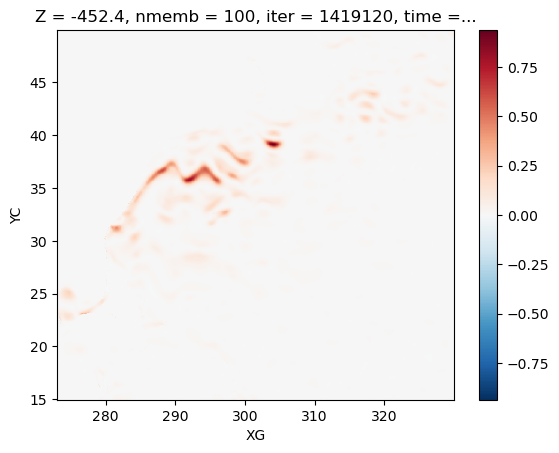

60000.0


In [8]:
dxT = grid.interp(ds.dxG, 'Y', boundary='extend')
dyT = grid.interp(ds.dyG, 'X', boundary='extend')
# grid info centered at U-points
dxCu = ds.dxC.swap_dims({"XG": "XC"})
dyCu = ds.dyG.swap_dims({"XG": "XC"})
area_u = dxCu * dyCu
# grid info centered at V-points
dxCv = ds.dxG.swap_dims({"YG": "YC"})
dyCv = ds.dyC.swap_dims({"YG": "YC"})
area_v = dxCv * dyCv

dxBu = grid.interp(ds.dxC,'Y',boundary='extend').swap_dims({"XG": "XC", "YG": "YC"})
dyBu = grid.interp(ds.dyC,'X',boundary='extend').swap_dims({"XG": "XC", "YG": "YC"})

dx_min = min(dxT.where(wet_mask_t).min(), dyT.where(wet_mask_t).min())
dx_min = dx_min.values

# dx_max = max(dxT.max(), dyT.max(), dxCu.max(), dyCu.max(), 
#              dxCv.max(), dyCv.max(), dxBu.max(), dyBu.max())
# dx_max = dx_max.values

kappa_iso = xr.ones_like(dxT)
kappa_aniso = xr.zeros_like(dyT)

for filter_scale in np.arange(60e3,70e3,10e3):
    
    filter_visc = gcm_filters.Filter(
        filter_scale=filter_scale,
        dx_min=dx_min,
        filter_shape=gcm_filters.FilterShape.GAUSSIAN,
        grid_type=gcm_filters.GridType.VECTOR_C_GRID,
        grid_vars={
            'wet_mask_t': wet_mask_t, 'wet_mask_q': wet_mask_q,
            'dxT': dxT, 'dyT': dyT, 
            'dxCu': dxCu, 'dyCu': dyCu, 'area_u': area_u, 
            'dxCv': dxCv, 'dyCv': dyCv, 'area_v': area_v,
            'dxBu': dxBu, 'dyBu': dyBu,
            'kappa_iso': kappa_iso, 'kappa_aniso': kappa_aniso
        }
    )
    
    # U  = u.swap_dims({'XG':'XC'}).reset_coords(drop=True)
    # V  = v.swap_dims({'YG':'YC'}).reset_coords(drop=True)
    ds_tmp = xr.Dataset()  # temporary dataset with swapped dimensions
    ds_tmp['uu'] = (u*u).isel(Z=[0,18])
    ds_tmp['vv'] = (v*v).isel(Z=[0,18])
    ds_tmp['uu'] = ds_tmp['uu'].swap_dims({'XG':'XC'})
    ds_tmp['vv'] = ds_tmp['vv'].swap_dims({'YG':'YC'})
    (uu_filtered, vv_filtered) = filter_visc.apply_to_vector(ds_tmp.uu, ds_tmp.vv, 
                                                             dims=['YC', 'XC'])
    uu_filtered = uu_filtered.swap_dims({"XC":"XG"}).isel(XG=slice(1,-1),YC=slice(1,-1))
    vv_filtered = vv_filtered.swap_dims({"YC":"YG"}).isel(YG=slice(1,-1),XC=slice(1,-1))
    ds_tmp.close()
    
    uu_filtered.isel(nmemb=0,Z=1).plot(rasterized=True)
    plt.show()
    
    
    dsave = uu_filtered.reset_coords(drop=True).to_dataset(name="uu")
    dsave.chunk({'YC':ychunk,'XG':xchunk}
               ).to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/uu.zarr' 
                                 % (iiter,int(filter_scale*1e-3))
                                ), mode='w')
    dsave.close()
    dsave = vv_filtered.reset_coords(drop=True).to_dataset(name='vv')
    dsave.chunk({'YG':ychunk,'XC':xchunk}
               ).to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/vv.zarr' 
                                 % (iiter,int(filter_scale*1e-3))
                                ), mode='w')
    dsave.close()

    print(filter_scale)

In [9]:
area = ds.rA

dxw = xr.DataArray(
    data=ds.dxC, 
    coords={'YC':ds.YC,'XC':ds.XC}, 
    dims=('YC','XC')
)
dyw = xr.DataArray(
    data=ds.dyG, 
    coords={'YC':ds.YC,'XC':ds.XC}, 
    dims=('YC','XC')
)
dxs = xr.DataArray(
    data=ds.dxG, 
    coords={'YC':ds.YC,'XC':ds.XC}, 
    dims=('YC','XC')
)
dys = xr.DataArray(
    data=ds.dyC, 
    coords={'YC':ds.YC,'XC':ds.XC}, 
    dims=('YC','XC')
)

dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min())
dx_min = dx_min.values

kappa_w = xr.ones_like(dxw)
kappa_s = xr.ones_like(dxw)

for filter_scale in np.arange(60e3,70e3,10e3):
    
    filter_ = gcm_filters.Filter(
        filter_scale=filter_scale,
        dx_min=dx_min,
        filter_shape=gcm_filters.FilterShape.TAPER,
        grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
        grid_vars={
            'wet_mask': wet_mask_t, 
            'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
            'kappa_w': kappa_w, 'kappa_s': kappa_s
        }
    )
    
    uv = (grid.interp(u,'X',boundary='extend') 
          * grid.interp(v,'Y',boundary='extend')
         ).isel(Z=[0,18]).reset_coords(drop=True)
    uv_filtered = filter_.apply(uv, dims=['YC', 'XC']
                               ).isel(YC=slice(1,-1),XC=slice(1,-1))
    
    dsave = uv_filtered.reset_coords(drop=True).to_dataset(name="uv")
    dsave.chunk({'YC':ychunk,'XC':xchunk}
               ).to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/uv.zarr' 
                                 % (iiter,int(filter_scale*1e-3))
                                ), mode='w')
    dsave.close()

    print(filter_scale)

60000.0


### $$-\Big\langle \big(\overline{u u'}^l - \overline{u}^l\overline{u'}^l\big)\overline{u'}^l_x + \big(\overline{uv'}^l - \overline{u}^l\overline{v'}^l + \overline{v u'}^l - \overline{v}^l\overline{u'}^l\big)\frac{\overline{u'}^l_y + \overline{v'}^l_x}{2} + \big(\overline{v v'}^l - \overline{v}^l\overline{v'}^l\big)\overline{v'}^l_y \Big\rangle$$

In [15]:
iiter = 1419120
dg = 1
dsb = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn'), 
                      grid_dir=gdir,
                      prefix=['snap_diagOcn'], delta_t=2e2,
                      iters=iiter, 
                     ).sel(YC=slice(15-dg/12,50+dg/12),
                           YG=slice(15-dg/12,50+dg/12),
                           XC=slice(273-dg/12,330+dg/12),
                           XG=slice(273-dg/12,330+dg/12)
                          ).isel(time=0, Z=[0,18])
if len(dsb.XG) > len(dsb.XC):
     dsb = dsb.isel(XG=slice(None,-1))
elif len(dsb.XG) < len(dsb.XC):
     dsb = dsb.isel(XC=slice(1,None))  
dsb = dsb.isel(YC=slice(1,-1),XC=slice(1,-1),
               YG=slice(1,-1),XG=slice(1,-1))

coords={'X':{'center':'XC', 'left':'XG'}, 
        'Y':{'center':'YC', 'left':'YG'}}
grid = Grid(dsb, periodic=[],
            coords=coords)
grid

<xgcm.Grid>
X Axis (not periodic, boundary=None):
  * center   XC --> left
  * left     XG --> center
Y Axis (not periodic, boundary=None):
  * center   YC --> left
  * left     YG --> center

In [27]:
fs = 95
dsu = xr.open_zarr(op.join(savedir,'Filtered/%03dkm/u.zarr' % fs))
dsv = xr.open_zarr(op.join(savedir,'Filtered/%03dkm/v.zarr' % fs))
dsUV = xr.open_zarr(op.join(savedir,'Filtered/%03dkm/U-V.zarr' % fs))
dsuup = xr.open_zarr(op.join(savedir,'Filtered/%03dkm/uup.zarr' % fs))
dsvup = xr.open_zarr(op.join(savedir,'Filtered/%03dkm/vup.zarr' % fs))
dsUV

<xarray.Dataset>
Dimensions:  (YC: 422, XG: 664, Z: 2, YG: 422, XC: 664)
Coordinates: (12/23)
    Depth    (YC, XG) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    PHrefC   (Z) float32 dask.array<chunksize=(1,), meta=np.ndarray>
  * XC       (XC) float32 273.0 273.1 273.2 273.3 ... 329.8 329.9 330.0 330.1
  * XG       (XG) float32 273.0 273.1 273.1 273.2 ... 329.8 329.9 329.9 330.0
  * YC       (YC) float32 14.92 15.0 15.08 15.17 ... 49.75 49.83 49.92 50.0
  * YG       (YG) float32 14.96 15.04 15.13 15.21 ... 49.79 49.88 49.96 50.04
    ...       ...
    maskInW  (YC, XG) bool dask.array<chunksize=(200, 200), meta=np.ndarray>
    rA       (YC, XG) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    rAs      (YC, XG) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    rAw      (YC, XG) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    rhoRef   (Z) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    time     timedelta64[ns] ...
Data variables:
    U        (Z, YC, XG) float32 dask.array<chunksize=(1, 200, 200), meta=np.ndarray>
    V        (Z, YG, XC) float32 dask.array<chunksize=(1, 200, 200), meta=np.ndarray>

In [37]:
up = (dsu.u - dsUV.U)
vp = (dsv.v - dsUV.V)
upx = grid.diff(up * (dsb.dyG * dsb.hFacW * dsb.drF), 
                'X', boundary='extend'
               ) / dsb.rA / dsb.drF / dsb.hFacC
vpy = grid.diff(vp * (dsb.dxG * dsb.hFacS * dsb.drF), 
                'Y', boundary='extend'
               ) / dsb.rA / dsb.drF / dsb.hFacC
upy = grid.interp(grid.interp(grid.diff(up * (dsb.dyG * dsb.hFacW * dsb.drF), 
                                        'Y', boundary='extend'
                                       ) / dsb.rAz / dsb.drF / grid.interp(dsb.hFacW,'Y',boundary='extend'),
                              'Y', boundary='extend'),
                  'X', boundary='extend')
vpx = grid.interp(grid.interp(grid.diff(vp * (dsb.dxG * dsb.hFacS * dsb.drF), 
                                        'X', boundary='extend'
                                       ) / dsb.rAz / dsb.drF / grid.interp(dsb.hFacS,'X',boundary='extend'),
                              'X', boundary='extend'),
                  'Y', boundary='extend')
vpx

<xarray.DataArray (nmemb: 48, Z: 2, YC: 420, XC: 662)>
dask.array<transpose, shape=(48, 2, 420, 662), dtype=float32, chunksize=(1, 1, 199, 199), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) >f4 273.1 273.2 273.3 273.4 273.4 ... 329.7 329.8 329.9 330.0
  * YC       (YC) >f4 15.0 15.08 15.17 15.25 15.33 ... 49.67 49.75 49.83 49.92
  * Z        (Z) >f4 -3.047 -452.4
Dimensions without coordinates: nmemb

In [44]:
Pi = -((dsuup.uup - grid.interp(dsu.u*up,'X',boundary='extend')) * upx
       + .5*(dsuup.uvp - grid.interp(dsu.u,'X',boundary='extend')
             * grid.interp(vp,'Y',boundary='extend')
             + dsvup.vup - grid.interp(dsv.v,'Y',boundary='extend')
             * grid.interp(up,'X',boundary='extend')
            ) * (upy+vpx)
       + (dsvup.vvp - grid.interp(dsv.v*vp,'Y',boundary='extend')) * vpy
      ).reset_coords(drop=True).mean('nmemb').compute()
Pi

<xarray.DataArray (Z: 2, YC: 420, XC: 662)>
array([[[            nan,             nan,             nan, ...,
          6.75736134e-11, -6.99260441e-11,  5.41147266e-11],
        [            nan,             nan,             nan, ...,
         -4.75974989e-11, -8.43436779e-11,  7.30305746e-11],
        [            nan,             nan,             nan, ...,
          2.77065506e-11, -1.37659788e-11,  6.80435500e-11],
        ...,
        [-6.67156014e-14,  2.76289137e-13,  2.13590281e-13, ...,
         -2.57928150e-08, -2.76858785e-08, -3.24879181e-08],
        [ 5.32732062e-13, -1.32193694e-13,  7.50189299e-14, ...,
          3.01933873e-08,  5.74408539e-08,  4.71035442e-08],
        [ 7.40741073e-13, -1.16365240e-12, -3.45993552e-13, ...,
          4.88564496e-08,  8.82095819e-08,  7.68279662e-08]],

       [[            nan,             nan,             nan, ...,
         -3.61559914e-11, -5.67183141e-11, -6.29548288e-11],
        [            nan,             nan,             nan, ...,
         -1.72720917e-11, -2.23551455e-11, -2.33008942e-11],
        [            nan,             nan,             nan, ...,
         -1.06644407e-11,  4.45216433e-12, -3.99266254e-12],
        ...,
        [            nan,             nan,             nan, ...,
         -1.43975754e-09, -1.93985961e-09, -1.56833391e-09],
        [            nan,             nan,             nan, ...,
          3.18250426e-09,  5.10286569e-09,  4.38663550e-09],
        [            nan,             nan,             nan, ...,
          4.68399364e-09,  9.60503055e-09,  1.05390505e-08]]],
      dtype=float32)
Coordinates:
  * XC       (XC) float32 273.1 273.2 273.3 273.4 ... 329.7 329.8 329.9 330.0
  * YC       (YC) float32 15.0 15.08 15.17 15.25 ... 49.67 49.75 49.83 49.92
  * Z        (Z) float32 -3.047 -452.4

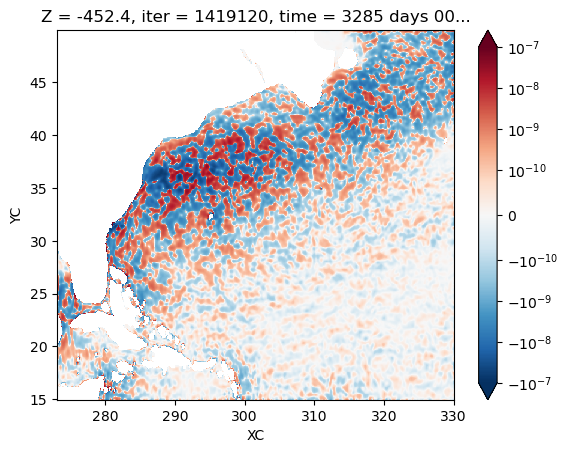

In [45]:
Pi.where(dsb.maskC!=0.).isel(Z=1).plot(rasterized=True, norm=clr.SymLogNorm(1e-10, vmin=-1e-7, vmax=1e-7))

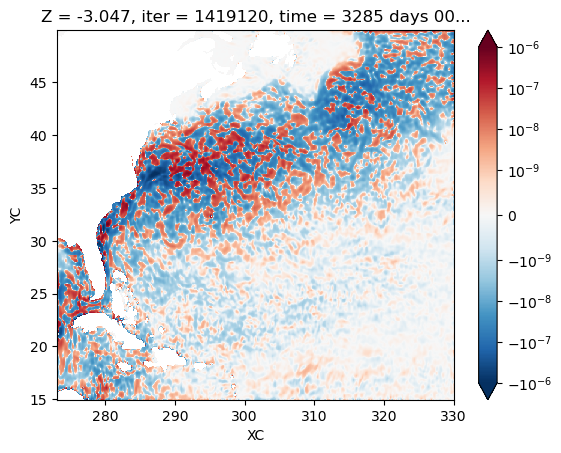

In [46]:
Pi.where(dsb.maskC!=0.).isel(Z=0).plot(rasterized=True, norm=clr.SymLogNorm(1e-9, vmin=-1e-6, vmax=1e-6))

In [8]:
years = np.arange(1967,1968,dtype=int)
ntimes = np.arange(1419120,1576800,dnf).reshape(len(years),nfile)
dd = 0  # 
yystart = 0
ntimes[yystart,dd:][::3]

array([1419120, 1425600, 1432080, 1438560, 1445040, 1451520, 1458000,
       1464480, 1470960, 1477440, 1483920, 1490400, 1496880, 1503360,
       1509840, 1516320, 1522800, 1529280, 1535760, 1542240, 1548720,
       1555200, 1561680, 1568160, 1574640])

In [9]:
nmembs = np.arange(100,148)
dg = 1

for iiter in ntimes[0,dd:][::3]:
    dsb = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn'), 
                          grid_dir=gdir,
                          prefix=['snap_diagOcn'], delta_t=2e2,
                          iters=iiter, 
                         ).sel(YC=slice(15-dg/12,50+dg/12),
                               YG=slice(15-dg/12,50+dg/12),
                               XC=slice(273-dg/12,330+dg/12),
                               XG=slice(273-dg/12,330+dg/12)
                              ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1}).isel(time=0)

    for nmemb in nmembs:
        if nmemb == 100:
            ds = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                         % (nmemb)), 
                                 grid_dir=gdir,
                                 prefix=['snap_diagOcn'], delta_t=2e2,
                                 iters=iiter, 
                                ).sel(YC=slice(15-dg/12,50+dg/12),
                                      YG=slice(15-dg/12,50+dg/12),
                                      XC=slice(273-dg/12,330+dg/12),
                                      XG=slice(273-dg/12,330+dg/12)
                                     ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1}).isel(time=0)
        else:
            ds = xr.concat([ds, open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                                        % (nmemb)), 
                                                grid_dir=gdir,
                                                prefix=['snap_diagOcn'], delta_t=2e2,
                                                iters=iiter, 
                                               ).sel(YC=slice(15-dg/12,50+dg/12),
                                                     YG=slice(15-dg/12,50+dg/12),
                                                     XC=slice(273-dg/12,330+dg/12),
                                                     XG=slice(273-dg/12,330+dg/12)
                                                    ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1}
                                                           ).isel(time=0)
                           ], dim='nmemb')

    if len(dsb.XG) > len(dsb.XC):
         dsb = dsb.isel(XG=slice(None,-1))
    elif len(dsb.XG) < len(dsb.XC):
         dsb = dsb.isel(XC=slice(1,None))  
    if len(ds.XG) > len(ds.XC):
         ds = ds.isel(XG=slice(None,-1))
    elif len(ds.XG) < len(ds.XC):
         ds = ds.isel(XC=slice(1,None))  
    # if len(dsb.YG) > len(dsb.YC):
    #      dsb = dsb.isel(YG=slice(None,-1))
    # if len(ds.YG) > len(ds.YC):
    #      ds = ds.isel(YG=slice(None,-1))

    ds.coords['nmemb'] = ('nmemb',nmembs)

    ub = dsb.UVEL
    vb = dsb.VVEL
    u = ds.UVEL
    v = ds.VVEL
    up = u - ub
    vp = v - vb

    grid = Grid(ds, periodic=[])
    
    if iiter == ntimes[0,dd]:
        # grid info centered at T-points
        wet_mask_t = ds.maskC.isel(Z=[0,18])
        wet_mask_t[dict(XC=-1)] = 0.
        wet_mask_t[dict(XC=0)] = 0.
        wet_mask_t[dict(YC=-1)] = 0.
        wet_mask_t[dict(YC=0)] = 0.

        # grid info centered at vorticity points
        wet_mask_q = grid.interp(ds.maskW, 'Y', boundary='extend'
                                ).isel(Z=[0,18]).swap_dims({"XG": "XC", "YG": "YC"})
        wet_mask_q[dict(XC=-1)] = 0.
        wet_mask_q[dict(XC=0)] = 0.
        wet_mask_q[dict(YC=-1)] = 0.
        wet_mask_q[dict(YC=0)] = 0.
    
        dxT = grid.interp(ds.dxG, 'Y', boundary='extend')
        dyT = grid.interp(ds.dyG, 'X', boundary='extend')
        # grid info centered at U-points
        dxCu = ds.dxC.swap_dims({"XG": "XC"})
        dyCu = ds.dyG.swap_dims({"XG": "XC"})
        area_u = dxCu * dyCu
        # grid info centered at V-points
        dxCv = ds.dxG.swap_dims({"YG": "YC"})
        dyCv = ds.dyC.swap_dims({"YG": "YC"})
        area_v = dxCv * dyCv

        dxBu = grid.interp(ds.dxC,'Y',boundary='extend'
                          ).swap_dims({"XG": "XC", "YG": "YC"})
        dyBu = grid.interp(ds.dyC,'X',boundary='extend'
                          ).swap_dims({"XG": "XC", "YG": "YC"})

        # dx_max = max(dxT.max() , dyT.max() , dxCu.max(), dyCu.max(), 
        #              dxCv.max(), dyCv.max(), dxBu.max(), dyBu.max())
        # dx_max = dx_max.values

        kappa_iso = xr.ones_like(dxT)
        kappa_aniso = xr.zeros_like(dyT)
        
    dx_min = min(dxT.where(wet_mask_t).min(), dyT.where(wet_mask_t).min())
    dx_min = dx_min.values
    
    if iiter == ntimes[0,dd]:
        scale_min = 15e3
    else:
        scale_min = 15e3
    for filter_scale in np.arange(scale_min,30e3,5e3):

        filter_visc = gcm_filters.Filter(
            filter_scale=filter_scale,
            dx_min=dx_min,
            filter_shape=gcm_filters.FilterShape.GAUSSIAN,
            grid_type=gcm_filters.GridType.VECTOR_C_GRID,
            grid_vars={
                'wet_mask_t': wet_mask_t, 'wet_mask_q': wet_mask_q,
                'dxT': dxT, 'dyT': dyT, 
                'dxCu': dxCu, 'dyCu': dyCu, 'area_u': area_u, 
                'dxCv': dxCv, 'dyCv': dyCv, 'area_v': area_v,
                'dxBu': dxBu, 'dyBu': dyBu,
                'kappa_iso': kappa_iso, 'kappa_aniso': kappa_aniso
            }
        )

        # U  = u.swap_dims({'XG':'XC'}).reset_coords(drop=True)
        # V  = v.swap_dims({'YG':'YC'}).reset_coords(drop=True)
        ds_tmp = xr.Dataset()  # temporary dataset with swapped dimensions
        ds_tmp['u'] = u.isel(Z=[0,18])
        ds_tmp['v'] = v.isel(Z=[0,18])
        ds_tmp['u'] = ds_tmp['u'].swap_dims({'XG':'XC'})
        ds_tmp['v'] = ds_tmp['v'].swap_dims({'YG':'YC'})
        (u_filtered, v_filtered) = filter_visc.apply_to_vector(ds_tmp.u, ds_tmp.v, 
                                                               dims=['YC', 'XC'])
        u_filtered = u_filtered.swap_dims({"XC":"XG"}).isel(XG=slice(1,-1),YC=slice(1,-1))
        v_filtered = v_filtered.swap_dims({"YC":"YG"}).isel(YG=slice(1,-1),XC=slice(1,-1))
        ds_tmp.close()

        # u_filtered.isel(nmemb=0,Z=1).plot(rasterized=True)
        # plt.show()
        # Ub = ub.swap_dims({'XG':'XC'}).reset_coords(drop=True)
        # Vb = vb.swap_dims({'YG':'YC'}).reset_coords(drop=True)
        ds_tmp = xr.Dataset()  # temporary dataset with swapped dimensions
        ds_tmp['U'] = ub.isel(Z=[0,18])
        ds_tmp['V'] = vb.isel(Z=[0,18])
        ds_tmp['U'] = ds_tmp['U'].swap_dims({'XG':'XC'})
        ds_tmp['V'] = ds_tmp['V'].swap_dims({'YG':'YC'})
        (U_filtered, V_filtered) = filter_visc.apply_to_vector(ds_tmp.U, ds_tmp.V, 
                                                               dims=['YC', 'XC'])
        ub_filtered = U_filtered.swap_dims({"XC":"XG"})
        vb_filtered = V_filtered.swap_dims({"YC":"YG"})
        ds_tmp.close()
        # Up = up.swap_dims({'XG':'XC'})
        # Vp = vp.swap_dims({'YG':'YC'})


        dsave = u_filtered.reset_coords(drop=True).to_dataset(name="u")
        dsave.chunk({'YC':ychunk,'XG':xchunk}
                   ).to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/u.zarr' 
                                     % (iiter,int(filter_scale*1e-3))
                                    ), mode='w')
        dsave.close()
        dsave = v_filtered.reset_coords(drop=True).to_dataset(name='v')
        dsave.chunk({'YG':ychunk,'XC':xchunk}
                   ).to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/v.zarr' 
                                     % (iiter,int(filter_scale*1e-3))
                                    ), mode='w')
        dsave.close()
        dsave = ub_filtered.to_dataset(name='U')
        dsave["V"] = vb_filtered
        dsave.chunk({'YG':ychunk,'YC':ychunk,
                     'XG':xchunk,'XC':xchunk}
                   ).to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/U-V.zarr' 
                                     % (iiter,int(filter_scale*1e-3))
                                    ), mode='w')
        dsave.close()
        
    if iiter == ntimes[0,dd]:
        area = ds.rA

        dxw = xr.DataArray(
            data=ds.dxC, 
            coords={'YC':ds.YC,'XC':ds.XC}, 
            dims=('YC','XC')
        )
        dyw = xr.DataArray(
            data=ds.dyG, 
            coords={'YC':ds.YC,'XC':ds.XC}, 
            dims=('YC','XC')
        )
        dxs = xr.DataArray(
            data=ds.dxG, 
            coords={'YC':ds.YC,'XC':ds.XC}, 
            dims=('YC','XC')
        )
        dys = xr.DataArray(
            data=ds.dyC, 
            coords={'YC':ds.YC,'XC':ds.XC}, 
            dims=('YC','XC')
        )


        kappa_w = xr.ones_like(dxw)
        kappa_s = xr.ones_like(dxw)
    
        dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min())
        dx_min = dx_min.values
        
    for filter_scale in np.arange(scale_min,30e3,5e3):

        filter_ = gcm_filters.Filter(
            filter_scale=filter_scale,
            dx_min=dx_min,
            filter_shape=gcm_filters.FilterShape.TAPER,
            grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
            grid_vars={
                'wet_mask': wet_mask_t, 
                'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
                'kappa_w': kappa_w, 'kappa_s': kappa_s
            }
        )

        uup = grid.interp(u*up,'X',boundary='extend'
                         ).isel(Z=[0,18]).reset_coords(drop=True)
        uup_filtered = filter_.apply(uup, dims=['YC', 'XC']
                                    ).isel(YC=slice(1,-1),XC=slice(1,-1))

        uvp = (grid.interp(u,'X',boundary='extend') 
               * grid.interp(vp,'Y',boundary='extend')
              ).isel(Z=[0,18]).reset_coords(drop=True)
        uvp_filtered = filter_.apply(uvp, dims=['YC', 'XC']
                                    ).isel(YC=slice(1,-1),XC=slice(1,-1))

        vup = (grid.interp(up,'X',boundary='extend') 
               * grid.interp(v,'Y',boundary='extend')
              ).isel(Z=[0,18]).reset_coords(drop=True)
        vup_filtered = filter_.apply(vup, dims=['YC', 'XC']
                                    ).isel(YC=slice(1,-1),XC=slice(1,-1))

        vvp = grid.interp(v*vp,'Y',boundary='extend'
                         ).isel(Z=[0,18]).reset_coords(drop=True)
        vvp_filtered = filter_.apply(vvp, dims=['YC', 'XC']
                                    ).isel(YC=slice(1,-1),XC=slice(1,-1))

#         upU = grid.interp(up*ub,'X',boundary='extend'
#                          ).isel(Z=18).reset_coords(drop=True)
#         upU_filtered = filter_.apply(upU, dims=['YC', 'XC'])

#         upV = (grid.interp(up,'X',boundary='extend') 
#                * grid.interp(vb,'Y',boundary='extend')
#               ).isel(Z=18).reset_coords(drop=True)
#         upV_filtered = filter_.apply(upV, dims=['YC', 'XC'])

#         vpU = (grid.interp(ub,'X',boundary='extend') 
#                * grid.interp(vp,'Y',boundary='extend')
#               ).isel(Z=18).reset_coords(drop=True)
#         vpU_filtered = filter_.apply(vpU, dims=['YC', 'XC'])

#         vpV = grid.interp(vp*vb,'Y',boundary='extend'
#                          ).isel(Z=18).reset_coords(drop=True)
#         vpV_filtered = filter_.apply(vpV, dims=['YC', 'XC'])

        dsave = uup_filtered.reset_coords(drop=True).to_dataset(name="uup")
        dsave["uvp"] = uvp_filtered.reset_coords(drop=True)
        dsave.chunk({'YC':ychunk,'XC':xchunk}
                   ).to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/uup.zarr' 
                                     % (iiter,int(filter_scale*1e-3))
                                    ), mode='w')
        dsave.close()
        dsave = vup_filtered.reset_coords(drop=True).to_dataset(name="vup")
        dsave["vvp"] = vvp_filtered.reset_coords(drop=True)
        dsave.chunk({'YC':ychunk,'XC':xchunk}
                   ).to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/vup.zarr' 
                                     % (iiter,int(filter_scale*1e-3))
                                    ), mode='w')
        dsave.close()
        # dsave = upU_filtered.to_dataset(name="upU")
        # dsave["upV"] = upV_filtered
        # dsave.chunk({'YC':ychunk,'XC':xchunk}
        #            ).to_zarr(op.join(savedir,'Filtered/%03dkm/uU.zarr' 
        #                              % (filter_scale*1e-3)), mode='w')
        # dsave.close()
        # dsave = vpU_filtered.to_dataset(name="vpU")
        # dsave["vpV"] = vpV_filtered
        # dsave.chunk({'YC':ychunk,'XC':xchunk}
        #            ).to_zarr(op.join(savedir,'Filtered/%03dkm/vU.zarr' 
        #                              % (filter_scale*1e-3)), mode='w')
        # dsave.close()
        
    dsb.close(); ds.close()
    print(iiter)

1529280
1535760
1542240
1548720
1555200
1561680
1568160
1574640


In [8]:
nmembs = np.arange(100,148)
dg = 1

for iiter in ntimes[0,dd:][::3]:
    dsb = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn'), 
                          grid_dir=gdir,
                          prefix=['snap_diagOcn'], delta_t=2e2,
                          iters=iiter, 
                         ).sel(YC=slice(15-dg/12,50+dg/12),
                               YG=slice(15-dg/12,50+dg/12),
                               XC=slice(273-dg/12,330+dg/12),
                               XG=slice(273-dg/12,330+dg/12)
                              ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1}).isel(time=0)

    ds = xr.open_zarr(op.join(diag, 'Snap/Eddy_horiAdv%010d.zarr' 
                              % iiter)
                     ).sel(YC=slice(15-dg/12,50+dg/12),
                           YG=slice(15-dg/12,50+dg/12),
                           XC=slice(273-dg/12,330+dg/12),
                           XG=slice(273-dg/12,330+dg/12)
                          ).chunk({'Z':1})

    if len(dsb.XG) > len(dsb.XC):
         dsb = dsb.isel(XG=slice(None,-1))
    elif len(dsb.XG) < len(dsb.XC):
         dsb = dsb.isel(XC=slice(1,None))  
    if len(ds.XG) > len(ds.XC):
         ds = ds.isel(XG=slice(None,-1))
    elif len(ds.XG) < len(ds.XC):
         ds = ds.isel(XC=slice(1,None))  
    # if len(dsb.YG) > len(dsb.YC):
    #      dsb = dsb.isel(YG=slice(None,-1))
    # if len(ds.YG) > len(ds.YC):
    #      ds = ds.isel(YG=slice(None,-1))

    grid = Grid(dsb, periodic=[])
    
    area = dsb.rA

    dxw = xr.DataArray(
            data=dsb.dxC, 
            coords={'YC':dsb.YC,'XC':dsb.XC}, 
            dims=('YC','XC')
        )
    dyw = xr.DataArray(
            data=dsb.dyG, 
            coords={'YC':dsb.YC,'XC':dsb.XC}, 
            dims=('YC','XC')
        )
    dxs = xr.DataArray(
            data=dsb.dxG, 
            coords={'YC':dsb.YC,'XC':dsb.XC}, 
            dims=('YC','XC')
        )
    dys = xr.DataArray(
            data=dsb.dyC, 
            coords={'YC':dsb.YC,'XC':dsb.XC}, 
            dims=('YC','XC')
        )

    kappa_w = xr.ones_like(dxw)
    kappa_s = xr.ones_like(dxw)
    
    dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min())
    dx_min = dx_min.values
    
    wet_mask_t = dsb.maskC.isel(Z=[0,18])
    wet_mask_t[dict(XC=-1)] = 0.
    wet_mask_t[dict(XC=0)] = 0.
    wet_mask_t[dict(YC=-1)] = 0.
    wet_mask_t[dict(YC=0)] = 0.
    
    if iiter == ntimes[0,dd]:
        scale_min = 15e3
    else:
        scale_min = 15e3
    for filter_scale in np.concatenate((np.arange(scale_min,30e3,5e3),
                                        np.arange(30e3,260e3,10e3))):

        filter_ = gcm_filters.Filter(
            filter_scale=filter_scale,
            dx_min=dx_min,
            filter_shape=gcm_filters.FilterShape.TAPER,
            grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
            grid_vars={
                'wet_mask': wet_mask_t, 
                'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
                'kappa_w': kappa_w, 'kappa_s': kappa_s
            }
        )

        uup_filtered = filter_.apply(ds.ADVx_Um.chunk({'YC':-1,'XC':-1}), 
                                     dims=['YC', 'XC']
                                    ).isel(YC=slice(1,-1),XC=slice(1,-1))
        vvp_filtered = filter_.apply(ds.ADVy_Vm.chunk({'YC':-1,'XC':-1}), 
                                     dims=['YC', 'XC']
                                    ).isel(YC=slice(1,-1),XC=slice(1,-1))


        dsave = uup_filtered.reset_coords(drop=True).to_dataset(name="uup")
        dsave['vvp'] = vvp_filtered.reset_coords(drop=True)
        dsave.chunk({'YC':ychunk,'XC':xchunk}
                   ).to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/ADVh_uup.zarr' 
                                     % (iiter,int(filter_scale*1e-3))
                                    ), mode='w')
        dsave.close()
    
    area = xr.DataArray(data=dsb.rAz, 
                        coords={'YG':dsb.YG,'XG':dsb.XG}, 
                        dims=('YG','XG')
                       )

    dxw = xr.DataArray(
            data=dsb.dxG, 
            coords={'YG':dsb.YG,'XG':dsb.XG}, 
            dims=('YG','XG')
        )
    dyw = xr.DataArray(
            data=dsb.dyC, 
            coords={'YG':dsb.YG,'XG':dsb.XG}, 
            dims=('YG','XG')
        )
    dxs = xr.DataArray(
            data=dsb.dxC, 
            coords={'YG':dsb.YG,'XG':dsb.XG}, 
            dims=('YG','XG')
        )
    dys = xr.DataArray(
            data=dsb.dyG, 
            coords={'YG':dsb.YG,'XG':dsb.XG}, 
            dims=('YG','XG')
        )

    kappa_w = xr.ones_like(dxw)
    kappa_s = xr.ones_like(dxw)
    
    dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min())
    dx_min = dx_min.values
    
    wet_mask_t = xr.DataArray(data=dsb.maskC,
                              coords={'Z':dsb.Z,'YG':dsb.YG,'XG':dsb.XG}, 
                              dims=('Z','YG','XG')
                             ).isel(Z=[0,18])
    wet_mask_t[dict(XG=-1)] = 0.
    wet_mask_t[dict(XG=0)] = 0.
    wet_mask_t[dict(YG=-1)] = 0.
    wet_mask_t[dict(YG=0)] = 0.
    
    if iiter == ntimes[0,dd]:
        scale_min = 15e3
    else:
        scale_min = 15e3
    for filter_scale in np.concatenate((np.arange(scale_min,30e3,5e3),
                                        np.arange(30e3,260e3,10e3))):

        filter_ = gcm_filters.Filter(
            filter_scale=filter_scale,
            dx_min=dx_min,
            filter_shape=gcm_filters.FilterShape.TAPER,
            grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
            grid_vars={
                'wet_mask': wet_mask_t, 
                'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
                'kappa_w': kappa_w, 'kappa_s': kappa_s
            }
        )

        uvp_filtered = filter_.apply(ds.ADVx_Vm.chunk({'YG':-1,'XG':-1}), 
                                     dims=['YG', 'XG']
                                    ).isel(YG=slice(1,-1),XG=slice(1,-1))
        vup_filtered = filter_.apply(ds.ADVy_Um.chunk({'YG':-1,'XG':-1}), 
                                     dims=['YG', 'XG']
                                    ).isel(YG=slice(1,-1),XG=slice(1,-1))

        dsave = uvp_filtered.reset_coords(drop=True).to_dataset(name="uvp")
        dsave['vup'] = vup_filtered.reset_coords(drop=True)
        dsave.chunk({'YG':ychunk,'XG':xchunk}
                   ).to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/ADVh_uvp.zarr' 
                                     % (iiter,int(filter_scale*1e-3))
                                    ), mode='w')
        dsave.close()
        
    
    dsb.close(); ds.close()
    print(iiter)

1419120
1425600
1432080
1438560
1445040
1451520
1458000
1464480
1470960
1477440
1483920
1490400
1496880
1503360
1509840
1516320
1522800
1529280
1535760
1542240
1548720
1555200
1561680
1568160
1574640


In [8]:
nntimes = np.arange(1421280,1576800+dnf,dnf)
tdir = '/tank/chaocean/qjamet/RUNS/ORAR/'
nmembs = np.concatenate((np.arange(24),np.arange(36,60)))
dg = 1

for iiter in nntimes[::3]:
    dsb = open_mdsdataset(op.join(tdir,'ensmean/run1967/'), 
                          grid_dir=gdir,
                          prefix=['diag_ocnTave'], delta_t=2e2,
                          iters=iiter, 
                         ).sel(YC=slice(15-dg/12,50+dg/12),
                               YG=slice(15-dg/12,50+dg/12),
                               XC=slice(273-dg/12,330+dg/12),
                               XG=slice(273-dg/12,330+dg/12)
                              ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1}).isel(time=0)

    ds = xr.open_zarr(op.join(diag, '5Dave/Eddy_horiAdv%010d.zarr' 
                              % iiter)
                     ).sel(YC=slice(15-dg/12,50+dg/12),
                           YG=slice(15-dg/12,50+dg/12),
                           XC=slice(273-dg/12,330+dg/12),
                           XG=slice(273-dg/12,330+dg/12)
                          ).chunk({'Z':1})

    if len(dsb.XG) > len(dsb.XC):
         dsb = dsb.isel(XG=slice(None,-1))
    elif len(dsb.XG) < len(dsb.XC):
         dsb = dsb.isel(XC=slice(1,None))  
    if len(ds.XG) > len(ds.XC):
         ds = ds.isel(XG=slice(None,-1))
    elif len(ds.XG) < len(ds.XC):
         ds = ds.isel(XC=slice(1,None))  
    # if len(dsb.YG) > len(dsb.YC):
    #      dsb = dsb.isel(YG=slice(None,-1))
    # if len(ds.YG) > len(ds.YC):
    #      ds = ds.isel(YG=slice(None,-1))

    grid = Grid(dsb, periodic=[])
    
    area = dsb.rA

    dxw = xr.DataArray(
            data=dsb.dxC, 
            coords={'YC':dsb.YC,'XC':dsb.XC}, 
            dims=('YC','XC')
        )
    dyw = xr.DataArray(
            data=dsb.dyG, 
            coords={'YC':dsb.YC,'XC':dsb.XC}, 
            dims=('YC','XC')
        )
    dxs = xr.DataArray(
            data=dsb.dxG, 
            coords={'YC':dsb.YC,'XC':dsb.XC}, 
            dims=('YC','XC')
        )
    dys = xr.DataArray(
            data=dsb.dyC, 
            coords={'YC':dsb.YC,'XC':dsb.XC}, 
            dims=('YC','XC')
        )

    kappa_w = xr.ones_like(dxw)
    kappa_s = xr.ones_like(dxw)
    
    dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min())
    dx_min = dx_min.values
    
    wet_mask_t = dsb.maskC.isel(Z=[0,18])
    wet_mask_t[dict(XC=-1)] = 0.
    wet_mask_t[dict(XC=0)] = 0.
    wet_mask_t[dict(YC=-1)] = 0.
    wet_mask_t[dict(YC=0)] = 0.
    
    if iiter == nntimes[0]:
        scale_min = 15e3
    else:
        scale_min = 15e3
    for filter_scale in np.concatenate((np.arange(scale_min,30e3,5e3),
                                        np.arange(30e3,260e3,10e3))):

        filter_ = gcm_filters.Filter(
            filter_scale=filter_scale,
            dx_min=dx_min,
            filter_shape=gcm_filters.FilterShape.TAPER,
            grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
            grid_vars={
                'wet_mask': wet_mask_t, 
                'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
                'kappa_w': kappa_w, 'kappa_s': kappa_s
            }
        )

        uup_filtered = filter_.apply(ds.ADVx_Um.chunk({'YC':-1,'XC':-1}), 
                                     dims=['YC', 'XC']
                                    ).isel(YC=slice(1,-1),XC=slice(1,-1))
        vvp_filtered = filter_.apply(ds.ADVy_Vm.chunk({'YC':-1,'XC':-1}), 
                                     dims=['YC', 'XC']
                                    ).isel(YC=slice(1,-1),XC=slice(1,-1))


        dsave = uup_filtered.reset_coords(drop=True).to_dataset(name="uup")
        dsave['vvp'] = vvp_filtered.reset_coords(drop=True)
        dsave.chunk({'YC':ychunk,'XC':xchunk}
                   ).to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/ADVh_uup_tave.zarr' 
                                     % (iiter,int(filter_scale*1e-3))
                                    ), mode='w')
        dsave.close()
        
        del uup_filtered, vvp_filtered
    
    area = xr.DataArray(data=dsb.rAz, 
                        coords={'YG':dsb.YG,'XG':dsb.XG}, 
                        dims=('YG','XG')
                       )

    dxw = xr.DataArray(
            data=dsb.dxG, 
            coords={'YG':dsb.YG,'XG':dsb.XG}, 
            dims=('YG','XG')
        )
    dyw = xr.DataArray(
            data=dsb.dyC, 
            coords={'YG':dsb.YG,'XG':dsb.XG}, 
            dims=('YG','XG')
        )
    dxs = xr.DataArray(
            data=dsb.dxC, 
            coords={'YG':dsb.YG,'XG':dsb.XG}, 
            dims=('YG','XG')
        )
    dys = xr.DataArray(
            data=dsb.dyG, 
            coords={'YG':dsb.YG,'XG':dsb.XG}, 
            dims=('YG','XG')
        )

    kappa_w = xr.ones_like(dxw)
    kappa_s = xr.ones_like(dxw)
    
    dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min())
    dx_min = dx_min.values
    
    wet_mask_t = xr.DataArray(data=dsb.maskC,
                              coords={'Z':dsb.Z,'YG':dsb.YG,'XG':dsb.XG}, 
                              dims=('Z','YG','XG')
                             ).isel(Z=[0,18])
    wet_mask_t[dict(XG=-1)] = 0.
    wet_mask_t[dict(XG=0)] = 0.
    wet_mask_t[dict(YG=-1)] = 0.
    wet_mask_t[dict(YG=0)] = 0.
    
    if iiter == nntimes[0]:
        scale_min = 15e3
    else:
        scale_min = 15e3
    for filter_scale in np.concatenate((np.arange(scale_min,30e3,5e3),
                                        np.arange(30e3,260e3,10e3))):

        filter_ = gcm_filters.Filter(
            filter_scale=filter_scale,
            dx_min=dx_min,
            filter_shape=gcm_filters.FilterShape.TAPER,
            grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
            grid_vars={
                'wet_mask': wet_mask_t, 
                'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
                'kappa_w': kappa_w, 'kappa_s': kappa_s
            }
        )

        uvp_filtered = filter_.apply(ds.ADVx_Vm.chunk({'YG':-1,'XG':-1}), 
                                     dims=['YG', 'XG']
                                    ).isel(YG=slice(1,-1),XG=slice(1,-1))
        vup_filtered = filter_.apply(ds.ADVy_Um.chunk({'YG':-1,'XG':-1}), 
                                     dims=['YG', 'XG']
                                    ).isel(YG=slice(1,-1),XG=slice(1,-1))

        dsave = uvp_filtered.reset_coords(drop=True).to_dataset(name="uvp")
        dsave['vup'] = vup_filtered.reset_coords(drop=True)
        dsave.chunk({'YG':ychunk,'XG':xchunk}
                   ).to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/ADVh_uvp_tave.zarr' 
                                     % (iiter,int(filter_scale*1e-3))
                                    ), mode='w')
        dsave.close()
        
        del uvp_filtered, vup_filtered
    
    dsb.close(); ds.close()
    print(iiter)

1421280
1427760
1434240
1440720
1447200
1453680
1460160
1466640
1473120
1479600
1486080
1492560
1499040
1505520
1512000
1518480
1524960
1531440
1537920
1544400
1550880
1557360
1563840
1570320
1576800


In [9]:
scale_min = 15e3

for iiter in ntimes[0,dd:][::3]:
    
    for filter_scale in np.arange(scale_min,30e3,5e3):
        dsu = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/u.zarr' 
                                   % (iiter,int(filter_scale*1e-3))
                                  )
                          ).chunk({"YC":ychunk,"XG":xchunk})
        dsv = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/v.zarr' 
                                   % (iiter,int(filter_scale*1e-3))
                                  )
                          ).chunk({"YG":ychunk,"XC":xchunk})
        dsUV = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/U-V.zarr' 
                                    % (iiter,int(filter_scale*1e-3))
                                   )
                           ).chunk({"YC":ychunk,"XC":xchunk,
                                    "YG":ychunk,"XG":xchunk})
        dsuup = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/uup.zarr' 
                                     % (iiter,int(filter_scale*1e-3))
                                    )
                            ).chunk({"YC":ychunk,"XC":xchunk})
        dsvup = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/vup.zarr' 
                                     % (iiter,int(filter_scale*1e-3))
                                    )
                            ).chunk({"YC":ychunk,"XC":xchunk})
        
        up = (dsu.u - dsUV.U)
        vp = (dsv.v - dsUV.V)
        
        upx = grid.diff(up * (dsb.dyG * dsb.hFacW * dsb.drF), 
                        'X', boundary='extend'
                       ) / dsb.rA / dsb.drF / dsb.hFacC
        vpy = grid.diff(vp * (dsb.dxG * dsb.hFacS * dsb.drF), 
                        'Y', boundary='extend'
                       ) / dsb.rA / dsb.drF / dsb.hFacC
        upy = grid.interp(grid.interp(grid.diff(up * (dsb.dyG * dsb.hFacW * dsb.drF), 
                                                'Y', boundary='extend'
                                               ) / dsb.rAz / dsb.drF 
                                      / grid.interp(dsb.hFacW,'Y',boundary='extend'),
                                      'Y', boundary='extend'),
                          'X', boundary='extend')
        vpx = grid.interp(grid.interp(grid.diff(vp * (dsb.dxG * dsb.hFacS * dsb.drF), 
                                                'X', boundary='extend'
                                               ) / dsb.rAz / dsb.drF 
                                      / grid.interp(dsb.hFacS,'X',boundary='extend'),
                                      'X', boundary='extend'),
                          'Y', boundary='extend')
        
        Pi = -((dsuup.uup - grid.interp(dsu.u*up,'X',boundary='extend')) * upx
               + .5*(dsuup.uvp - grid.interp(dsu.u,'X',boundary='extend')
                     * grid.interp(vp,'Y',boundary='extend')
                     + dsvup.vup - grid.interp(dsv.v,'Y',boundary='extend')
                     * grid.interp(up,'X',boundary='extend')
                    ) * (upy+vpx)
               + (dsvup.vvp - grid.interp(dsv.v*vp,'Y',boundary='extend')) * vpy
              ).reset_coords(drop=True)
        
        # if iiter == ntimes[0,0]:
        #     fig, ax = plt.subplots()
        #     Pi.isel(Z=1).mean('nmemb').plot(ax=ax, rasterized=True, 
        #                                     norm=clr.SymLogNorm(1e-10, vmin=-1e-7, vmax=1e-7))
        #     ax.set_aspect('equal')
        #     plt.show()
        
        dsave = Pi.chunk({"YC":ychunk,"XC":xchunk}).to_dataset(name='Pi')
        dsave.to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/Pi.zarr' 
                              % (iiter,int(filter_scale*1e-3))
                             ), mode='w')
        dsave.close()
        
    print(iiter)

1477440
1483920
1490400
1496880
1503360
1509840
1516320
1522800
1529280
1535760
1542240
1548720
1555200
1561680
1568160
1574640


In [18]:
nmembs = np.arange(100,148)
dg = 1

for iiter in ntimes[0,dd:][::3]:

    for nmemb in nmembs:
        if nmemb == 100:
            ds = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                         % (nmemb)), 
                                 grid_dir=gdir,
                                 prefix=['snap_diagOcn'], delta_t=2e2,
                                 iters=iiter, 
                                ).sel(YC=slice(15-dg/12,50+dg/12),
                                      YG=slice(15-dg/12,50+dg/12),
                                      XC=slice(273-dg/12,330+dg/12),
                                      XG=slice(273-dg/12,330+dg/12)
                                     ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1}).isel(time=0)
        else:
            ds = xr.concat([ds, open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                                        % (nmemb)), 
                                                grid_dir=gdir,
                                                prefix=['snap_diagOcn'], delta_t=2e2,
                                                iters=iiter, 
                                               ).sel(YC=slice(15-dg/12,50+dg/12),
                                                     YG=slice(15-dg/12,50+dg/12),
                                                     XC=slice(273-dg/12,330+dg/12),
                                                     XG=slice(273-dg/12,330+dg/12)
                                                    ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1}
                                                           ).isel(time=0)
                           ], dim='nmemb')
 
    if len(ds.XG) > len(ds.XC):
         ds = ds.isel(XG=slice(None,-1))
    elif len(ds.XG) < len(ds.XC):
         ds = ds.isel(XC=slice(1,None))  
    # if len(dsb.YG) > len(dsb.YC):
    #      dsb = dsb.isel(YG=slice(None,-1))
    # if len(ds.YG) > len(ds.YC):
    #      ds = ds.isel(YG=slice(None,-1))

    ds.coords['nmemb'] = ('nmemb',nmembs)

    ub = dsb.UVEL
    vb = dsb.VVEL
    u = ds.UVEL
    v = ds.VVEL
    up = u - ub
    vp = v - vb

    grid = Grid(ds, periodic=[])
    
    if iiter == ntimes[0,dd]:
        # grid info centered at T-points
        wet_mask_t = ds.maskC.isel(Z=[0,18])
        wet_mask_t[dict(XC=-1)] = 0.
        wet_mask_t[dict(XC=0)] = 0.
        wet_mask_t[dict(YC=-1)] = 0.
        wet_mask_t[dict(YC=0)] = 0.

        # grid info centered at vorticity points
        wet_mask_q = grid.interp(ds.maskW, 'Y', boundary='extend'
                                ).isel(Z=[0,18]).swap_dims({"XG": "XC", "YG": "YC"})
        wet_mask_q[dict(XC=-1)] = 0.
        wet_mask_q[dict(XC=0)] = 0.
        wet_mask_q[dict(YC=-1)] = 0.
        wet_mask_q[dict(YC=0)] = 0.
    
        dxT = grid.interp(ds.dxG, 'Y', boundary='extend')
        dyT = grid.interp(ds.dyG, 'X', boundary='extend')
        # grid info centered at U-points
        dxCu = ds.dxC.swap_dims({"XG": "XC"})
        dyCu = ds.dyG.swap_dims({"XG": "XC"})
        area_u = dxCu * dyCu
        # grid info centered at V-points
        dxCv = ds.dxG.swap_dims({"YG": "YC"})
        dyCv = ds.dyC.swap_dims({"YG": "YC"})
        area_v = dxCv * dyCv

        dxBu = grid.interp(ds.dxC,'Y',boundary='extend'
                          ).swap_dims({"XG": "XC", "YG": "YC"})
        dyBu = grid.interp(ds.dyC,'X',boundary='extend'
                          ).swap_dims({"XG": "XC", "YG": "YC"})

        # dx_max = max(dxT.max() , dyT.max() , dxCu.max(), dyCu.max(), 
        #              dxCv.max(), dyCv.max(), dxBu.max(), dyBu.max())
        # dx_max = dx_max.values

        kappa_iso = xr.ones_like(dxT)
        kappa_aniso = xr.zeros_like(dyT)
        
    dx_min = min(dxT.where(wet_mask_t).min(), dyT.where(wet_mask_t).min())
    dx_min = dx_min.values
    
    if iiter == ntimes[0,dd]:
        scale_min = 60e3
    else:
        scale_min = 60e3
    for filter_scale in np.arange(scale_min,70e3,10e3):

        filter_visc = gcm_filters.Filter(
            filter_scale=filter_scale,
            dx_min=dx_min,
            filter_shape=gcm_filters.FilterShape.GAUSSIAN,
            grid_type=gcm_filters.GridType.VECTOR_C_GRID,
            grid_vars={
                'wet_mask_t': wet_mask_t, 'wet_mask_q': wet_mask_q,
                'dxT': dxT, 'dyT': dyT, 
                'dxCu': dxCu, 'dyCu': dyCu, 'area_u': area_u, 
                'dxCv': dxCv, 'dyCv': dyCv, 'area_v': area_v,
                'dxBu': dxBu, 'dyBu': dyBu,
                'kappa_iso': kappa_iso, 'kappa_aniso': kappa_aniso
            }
        )

        # U  = u.swap_dims({'XG':'XC'}).reset_coords(drop=True)
        # V  = v.swap_dims({'YG':'YC'}).reset_coords(drop=True)
        ds_tmp = xr.Dataset()  # temporary dataset with swapped dimensions
        ds_tmp['uu'] = (u*u).isel(Z=[0,18])
        ds_tmp['vv'] = (v*v).isel(Z=[0,18])
        ds_tmp['uu'] = ds_tmp['uu'].swap_dims({'XG':'XC'})
        ds_tmp['vv'] = ds_tmp['vv'].swap_dims({'YG':'YC'})
        (uu_filtered, vv_filtered) = filter_visc.apply_to_vector(ds_tmp.uu, ds_tmp.vv, 
                                                                 dims=['YC', 'XC'])
        uu_filtered = uu_filtered.swap_dims({"XC":"XG"}).isel(XG=slice(1,-1),YC=slice(1,-1))
        vv_filtered = vv_filtered.swap_dims({"YC":"YG"}).isel(YG=slice(1,-1),XC=slice(1,-1))
        ds_tmp.close()


        dsave = uu_filtered.reset_coords(drop=True).to_dataset(name="uu")
        dsave.chunk({'YC':ychunk,'XG':xchunk}
                   ).to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/uu.zarr' 
                                     % (iiter,int(filter_scale*1e-3))
                                    ), mode='w')
        dsave.close()
        dsave = vv_filtered.reset_coords(drop=True).to_dataset(name='vv')
        dsave.chunk({'YG':ychunk,'XC':xchunk}
                   ).to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/vv.zarr' 
                                     % (iiter,int(filter_scale*1e-3))
                                    ), mode='w')
        dsave.close()
        
    if iiter == ntimes[0,dd]:
        area = ds.rA

        dxw = xr.DataArray(
            data=ds.dxC, 
            coords={'YC':ds.YC,'XC':ds.XC}, 
            dims=('YC','XC')
        )
        dyw = xr.DataArray(
            data=ds.dyG, 
            coords={'YC':ds.YC,'XC':ds.XC}, 
            dims=('YC','XC')
        )
        dxs = xr.DataArray(
            data=ds.dxG, 
            coords={'YC':ds.YC,'XC':ds.XC}, 
            dims=('YC','XC')
        )
        dys = xr.DataArray(
            data=ds.dyC, 
            coords={'YC':ds.YC,'XC':ds.XC}, 
            dims=('YC','XC')
        )


        kappa_w = xr.ones_like(dxw)
        kappa_s = xr.ones_like(dxw)
    
    dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min())
    dx_min = dx_min.values
        
    for filter_scale in np.arange(scale_min,70e3,10e3):

        filter_ = gcm_filters.Filter(
            filter_scale=filter_scale,
            dx_min=dx_min,
            filter_shape=gcm_filters.FilterShape.TAPER,
            grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
            grid_vars={
                'wet_mask': wet_mask_t, 
                'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
                'kappa_w': kappa_w, 'kappa_s': kappa_s
            }
        )

        uv = (grid.interp(u,'X',boundary='extend') 
              * grid.interp(v,'Y',boundary='extend')
             ).isel(Z=[0,18]).reset_coords(drop=True)
        uv_filtered = filter_.apply(uv, dims=['YC', 'XC']
                                   ).isel(YC=slice(1,-1),XC=slice(1,-1))

        
        dsave = uv_filtered.reset_coords(drop=True).to_dataset(name="uv")
        dsave.chunk({'YC':ychunk,'XC':xchunk}
                   ).to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/uv.zarr' 
                                     % (iiter,int(filter_scale*1e-3))
                                    ), mode='w')
        dsave.close()
        
    dsb.close(); ds.close()
    print(iiter)

1419120
1425600
1432080
1438560
1445040
1451520
1458000
1464480
1470960
1477440
1483920
1490400
1496880
1503360
1509840
1516320
1522800
1529280
1535760
1542240
1548720
1555200
1561680
1568160
1574640


In [9]:
nmembs = np.arange(100,148)
dg = 1

for iiter in ntimes[0,dd:][::3]:
    dsb = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn'), 
                          grid_dir=gdir,
                          prefix=['snap_diagOcn'], delta_t=2e2,
                          iters=iiter, 
                         ).sel(YC=slice(15-dg/12,50+dg/12),
                               YG=slice(15-dg/12,50+dg/12),
                               XC=slice(273-dg/12,330+dg/12),
                               XG=slice(273-dg/12,330+dg/12)
                              ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1}).isel(time=0)

    ds = xr.open_zarr(op.join(diag, 'Snap/Tot_horiAdv%010d.zarr' 
                              % iiter)
                     ).sel(YC=slice(15-dg/12,50+dg/12),
                           YG=slice(15-dg/12,50+dg/12),
                           XC=slice(273-dg/12,330+dg/12),
                           XG=slice(273-dg/12,330+dg/12)
                          ).chunk({'Z':1})

    if len(dsb.XG) > len(dsb.XC):
         dsb = dsb.isel(XG=slice(None,-1))
    elif len(dsb.XG) < len(dsb.XC):
         dsb = dsb.isel(XC=slice(1,None))  
    if len(ds.XG) > len(ds.XC):
         ds = ds.isel(XG=slice(None,-1))
    elif len(ds.XG) < len(ds.XC):
         ds = ds.isel(XC=slice(1,None))  
    # if len(dsb.YG) > len(dsb.YC):
    #      dsb = dsb.isel(YG=slice(None,-1))
    # if len(ds.YG) > len(ds.YC):
    #      ds = ds.isel(YG=slice(None,-1))

    grid = Grid(dsb, periodic=[])
    
    area = dsb.rA

    dxw = xr.DataArray(
            data=dsb.dxC, 
            coords={'YC':dsb.YC,'XC':dsb.XC}, 
            dims=('YC','XC')
        )
    dyw = xr.DataArray(
            data=dsb.dyG, 
            coords={'YC':dsb.YC,'XC':dsb.XC}, 
            dims=('YC','XC')
        )
    dxs = xr.DataArray(
            data=dsb.dxG, 
            coords={'YC':dsb.YC,'XC':dsb.XC}, 
            dims=('YC','XC')
        )
    dys = xr.DataArray(
            data=dsb.dyC, 
            coords={'YC':dsb.YC,'XC':dsb.XC}, 
            dims=('YC','XC')
        )

    kappa_w = xr.ones_like(dxw)
    kappa_s = xr.ones_like(dxw)
    
    dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min())
    dx_min = dx_min.values
    
    wet_mask_t = dsb.maskC.isel(Z=[0,18])
    wet_mask_t[dict(XC=-1)] = 0.
    wet_mask_t[dict(XC=0)] = 0.
    wet_mask_t[dict(YC=-1)] = 0.
    wet_mask_t[dict(YC=0)] = 0.
    
    if iiter == ntimes[0,dd]:
        scale_min = 15e3
    else:
        scale_min = 15e3
    for filter_scale in np.concatenate((np.arange(scale_min,30e3,5e3),
                                        np.arange(30e3,260e3,10e3))):

        filter_ = gcm_filters.Filter(
            filter_scale=filter_scale,
            dx_min=dx_min,
            filter_shape=gcm_filters.FilterShape.TAPER,
            grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
            grid_vars={
                'wet_mask': wet_mask_t, 
                'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
                'kappa_w': kappa_w, 'kappa_s': kappa_s
            }
        )

        uu_filtered = filter_.apply(ds.ADVx_Um.chunk({'YC':-1,'XC':-1}), 
                                     dims=['YC', 'XC']
                                    ).isel(YC=slice(1,-1),XC=slice(1,-1))
        vv_filtered = filter_.apply(ds.ADVy_Vm.chunk({'YC':-1,'XC':-1}), 
                                     dims=['YC', 'XC']
                                    ).isel(YC=slice(1,-1),XC=slice(1,-1))


        dsave = uu_filtered.reset_coords(drop=True).to_dataset(name="uu")
        dsave['vv'] = vv_filtered.reset_coords(drop=True)
        dsave.chunk({'YC':ychunk,'XC':xchunk}
                   ).to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/ADVh_uu.zarr' 
                                     % (iiter,int(filter_scale*1e-3))
                                    ), mode='w')
        dsave.close()
        
        del uu_filtered, vv_filtered
    
    area = xr.DataArray(data=dsb.rAz, 
                        coords={'YG':dsb.YG,'XG':dsb.XG}, 
                        dims=('YG','XG')
                       )

    dxw = xr.DataArray(
            data=dsb.dxG, 
            coords={'YG':dsb.YG,'XG':dsb.XG}, 
            dims=('YG','XG')
        )
    dyw = xr.DataArray(
            data=dsb.dyC, 
            coords={'YG':dsb.YG,'XG':dsb.XG}, 
            dims=('YG','XG')
        )
    dxs = xr.DataArray(
            data=dsb.dxC, 
            coords={'YG':dsb.YG,'XG':dsb.XG}, 
            dims=('YG','XG')
        )
    dys = xr.DataArray(
            data=dsb.dyG, 
            coords={'YG':dsb.YG,'XG':dsb.XG}, 
            dims=('YG','XG')
        )

    kappa_w = xr.ones_like(dxw)
    kappa_s = xr.ones_like(dxw)
    
    dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min())
    dx_min = dx_min.values
    
    wet_mask_t = xr.DataArray(data=dsb.maskC,
                              coords={'Z':dsb.Z,'YG':dsb.YG,'XG':dsb.XG}, 
                              dims=('Z','YG','XG')
                             ).isel(Z=[0,18])
    wet_mask_t[dict(XG=-1)] = 0.
    wet_mask_t[dict(XG=0)] = 0.
    wet_mask_t[dict(YG=-1)] = 0.
    wet_mask_t[dict(YG=0)] = 0.
    
    if iiter == ntimes[0,dd]:
        scale_min = 15e3
    else:
        scale_min = 15e3
    for filter_scale in np.concatenate((np.arange(scale_min,30e3,5e3),
                                        np.arange(30e3,260e3,10e3))):

        filter_ = gcm_filters.Filter(
            filter_scale=filter_scale,
            dx_min=dx_min,
            filter_shape=gcm_filters.FilterShape.TAPER,
            grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
            grid_vars={
                'wet_mask': wet_mask_t, 
                'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
                'kappa_w': kappa_w, 'kappa_s': kappa_s
            }
        )

        uv_filtered = filter_.apply(ds.ADVx_Vm.chunk({'YG':-1,'XG':-1}), 
                                     dims=['YG', 'XG']
                                    ).isel(YG=slice(1,-1),XG=slice(1,-1))
        vu_filtered = filter_.apply(ds.ADVy_Um.chunk({'YG':-1,'XG':-1}), 
                                     dims=['YG', 'XG']
                                    ).isel(YG=slice(1,-1),XG=slice(1,-1))

        dsave = uv_filtered.reset_coords(drop=True).to_dataset(name="uv")
        dsave['vu'] = vu_filtered.reset_coords(drop=True)
        dsave.chunk({'YG':ychunk,'XG':xchunk}
                   ).to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/ADVh_uv.zarr' 
                                     % (iiter,int(filter_scale*1e-3))
                                    ), mode='w')
        dsave.close()
        
        del uv_filtered, vu_filtered
        
    
    dsb.close(); ds.close()
    print(iiter)

1419120
1425600
1432080
1438560
1445040
1451520
1458000
1464480
1470960
1477440
1483920
1490400
1496880
1503360
1509840
1516320
1522800
1529280
1535760
1542240
1548720
1555200
1561680
1568160
1574640


In [15]:
ntimes = np.arange(1421280,1576800+dnf,dnf)
nmembs = np.concatenate((np.arange(24),np.arange(36,60)))
dg = 1

for iiter in ntimes[::3]:

    for nmemb in nmembs:
        if nmemb == nmembs[0]:
            ds = open_mdsdataset(op.join(tdir,'memb%02d/run1967/ocn/' 
                                         % (nmemb)), 
                                 grid_dir=gdir,
                                 prefix=['diag_ocnTave'], delta_t=2e2,
                                 iters=iiter, 
                                ).sel(YC=slice(15-dg/12,50+dg/12),
                                      YG=slice(15-dg/12,50+dg/12),
                                      XC=slice(273-dg/12,330+dg/12),
                                      XG=slice(273-dg/12,330+dg/12)
                                     ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1}).isel(time=0)
        else:
            ds = xr.concat([ds, open_mdsdataset(op.join(tdir,'memb%02d/run1967/ocn/' 
                                                        % (nmemb)), 
                                                grid_dir=gdir,
                                                prefix=['diag_ocnTave'], delta_t=2e2,
                                                iters=iiter, 
                                               ).sel(YC=slice(15-dg/12,50+dg/12),
                                                     YG=slice(15-dg/12,50+dg/12),
                                                     XC=slice(273-dg/12,330+dg/12),
                                                     XG=slice(273-dg/12,330+dg/12)
                                                    ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1}
                                                           ).isel(time=0)
                           ], dim='nmemb')
 
    if len(ds.XG) > len(ds.XC):
         ds = ds.isel(XG=slice(None,-1))
    elif len(ds.XG) < len(ds.XC):
         ds = ds.isel(XC=slice(1,None))  
    # if len(dsb.YG) > len(dsb.YC):
    #      dsb = dsb.isel(YG=slice(None,-1))
    # if len(ds.YG) > len(ds.YC):
    #      ds = ds.isel(YG=slice(None,-1))

    ds.coords['nmemb'] = ('nmemb',nmembs)

    u = ds.UVEL
    v = ds.VVEL

    grid = Grid(ds, periodic=[])
    
    if iiter == ntimes[0]:
        # grid info centered at T-points
        wet_mask_t = ds.maskC.isel(Z=[0,18])
        wet_mask_t[dict(XC=-1)] = 0.
        wet_mask_t[dict(XC=0)] = 0.
        wet_mask_t[dict(YC=-1)] = 0.
        wet_mask_t[dict(YC=0)] = 0.

        # grid info centered at vorticity points
        wet_mask_q = grid.interp(ds.maskW, 'Y', boundary='extend'
                                ).isel(Z=[0,18]).swap_dims({"XG": "XC", "YG": "YC"})
        wet_mask_q[dict(XC=-1)] = 0.
        wet_mask_q[dict(XC=0)] = 0.
        wet_mask_q[dict(YC=-1)] = 0.
        wet_mask_q[dict(YC=0)] = 0.
    
        dxT = grid.interp(ds.dxG, 'Y', boundary='extend')
        dyT = grid.interp(ds.dyG, 'X', boundary='extend')
        # grid info centered at U-points
        dxCu = ds.dxC.swap_dims({"XG": "XC"})
        dyCu = ds.dyG.swap_dims({"XG": "XC"})
        area_u = dxCu * dyCu
        # grid info centered at V-points
        dxCv = ds.dxG.swap_dims({"YG": "YC"})
        dyCv = ds.dyC.swap_dims({"YG": "YC"})
        area_v = dxCv * dyCv

        dxBu = grid.interp(ds.dxC,'Y',boundary='extend'
                          ).swap_dims({"XG": "XC", "YG": "YC"})
        dyBu = grid.interp(ds.dyC,'X',boundary='extend'
                          ).swap_dims({"XG": "XC", "YG": "YC"})

        # dx_max = max(dxT.max() , dyT.max() , dxCu.max(), dyCu.max(), 
        #              dxCv.max(), dyCv.max(), dxBu.max(), dyBu.max())
        # dx_max = dx_max.values

        kappa_iso = xr.ones_like(dxT)
        kappa_aniso = xr.zeros_like(dyT)
        
    dx_min = min(dxT.where(wet_mask_t).min(), dyT.where(wet_mask_t).min())
    dx_min = dx_min.values
    
    if iiter == ntimes[0]:
        scale_min = 60e3
    else:
        scale_min = 60e3
    for filter_scale in np.arange(scale_min,70e3,10e3):

        filter_visc = gcm_filters.Filter(
            filter_scale=filter_scale,
            dx_min=dx_min,
            filter_shape=gcm_filters.FilterShape.GAUSSIAN,
            grid_type=gcm_filters.GridType.VECTOR_C_GRID,
            grid_vars={
                'wet_mask_t': wet_mask_t, 'wet_mask_q': wet_mask_q,
                'dxT': dxT, 'dyT': dyT, 
                'dxCu': dxCu, 'dyCu': dyCu, 'area_u': area_u, 
                'dxCv': dxCv, 'dyCv': dyCv, 'area_v': area_v,
                'dxBu': dxBu, 'dyBu': dyBu,
                'kappa_iso': kappa_iso, 'kappa_aniso': kappa_aniso
            }
        )

        ds_tmp = xr.Dataset()  # temporary dataset with swapped dimensions
        ds_tmp['u'] = u.isel(Z=[0,18])
        ds_tmp['v'] = v.isel(Z=[0,18])
        ds_tmp['u'] = ds_tmp['u'].swap_dims({'XG':'XC'})
        ds_tmp['v'] = ds_tmp['v'].swap_dims({'YG':'YC'})
        (u_filtered, v_filtered) = filter_visc.apply_to_vector(ds_tmp.u, ds_tmp.v, 
                                                               dims=['YC', 'XC'])
        u_filtered = u_filtered.swap_dims({"XC":"XG"}).isel(XG=slice(1,-1),YC=slice(1,-1))
        v_filtered = v_filtered.swap_dims({"YC":"YG"}).isel(YG=slice(1,-1),XC=slice(1,-1))
        ds_tmp.close()
        
        dsave = u_filtered.reset_coords(drop=True).to_dataset(name="u")
        dsave.chunk({'YC':ychunk,'XG':xchunk}
                   ).to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/u_tave.zarr' 
                                     % (iiter,int(filter_scale*1e-3))
                                    ), mode='w')
        dsave.close()
        dsave = v_filtered.reset_coords(drop=True).to_dataset(name='v')
        dsave.chunk({'YG':ychunk,'XC':xchunk}
                   ).to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/v_tave.zarr' 
                                     % (iiter,int(filter_scale*1e-3))
                                    ), mode='w')
        dsave.close()
        
        ds_tmp = xr.Dataset()  # temporary dataset with swapped dimensions
        ds_tmp['uu'] = (u*u).isel(Z=[0,18])
        ds_tmp['vv'] = (v*v).isel(Z=[0,18])
        ds_tmp['uu'] = ds_tmp['uu'].swap_dims({'XG':'XC'})
        ds_tmp['vv'] = ds_tmp['vv'].swap_dims({'YG':'YC'})
        (uu_filtered, vv_filtered) = filter_visc.apply_to_vector(ds_tmp.uu, ds_tmp.vv, 
                                                                 dims=['YC', 'XC'])
        uu_filtered = uu_filtered.swap_dims({"XC":"XG"}).isel(XG=slice(1,-1),YC=slice(1,-1))
        vv_filtered = vv_filtered.swap_dims({"YC":"YG"}).isel(YG=slice(1,-1),XC=slice(1,-1))
        ds_tmp.close()


        dsave = uu_filtered.reset_coords(drop=True).to_dataset(name="uu")
        dsave.chunk({'YC':ychunk,'XG':xchunk}
                   ).to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/uu_tave.zarr' 
                                     % (iiter,int(filter_scale*1e-3))
                                    ), mode='w')
        dsave.close()
        dsave = vv_filtered.reset_coords(drop=True).to_dataset(name='vv')
        dsave.chunk({'YG':ychunk,'XC':xchunk}
                   ).to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/vv_tave.zarr' 
                                     % (iiter,int(filter_scale*1e-3))
                                    ), mode='w')
        dsave.close()
        
    if iiter == ntimes[0]:
        area = ds.rA

        dxw = xr.DataArray(
            data=ds.dxC, 
            coords={'YC':ds.YC,'XC':ds.XC}, 
            dims=('YC','XC')
        )
        dyw = xr.DataArray(
            data=ds.dyG, 
            coords={'YC':ds.YC,'XC':ds.XC}, 
            dims=('YC','XC')
        )
        dxs = xr.DataArray(
            data=ds.dxG, 
            coords={'YC':ds.YC,'XC':ds.XC}, 
            dims=('YC','XC')
        )
        dys = xr.DataArray(
            data=ds.dyC, 
            coords={'YC':ds.YC,'XC':ds.XC}, 
            dims=('YC','XC')
        )


        kappa_w = xr.ones_like(dxw)
        kappa_s = xr.ones_like(dxw)
    
    dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min())
    dx_min = dx_min.values
        
    for filter_scale in np.arange(scale_min,70e3,10e3):

        filter_ = gcm_filters.Filter(
            filter_scale=filter_scale,
            dx_min=dx_min,
            filter_shape=gcm_filters.FilterShape.TAPER,
            grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
            grid_vars={
                'wet_mask': wet_mask_t, 
                'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
                'kappa_w': kappa_w, 'kappa_s': kappa_s
            }
        )

        uv = (grid.interp(u,'X',boundary='extend') 
              * grid.interp(v,'Y',boundary='extend')
             ).isel(Z=[0,18]).reset_coords(drop=True)
        uv_filtered = filter_.apply(uv, dims=['YC', 'XC']
                                   ).isel(YC=slice(1,-1),XC=slice(1,-1))

        
        dsave = uv_filtered.reset_coords(drop=True).to_dataset(name="uv")
        dsave.chunk({'YC':ychunk,'XC':xchunk}
                   ).to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/uv_tave.zarr' 
                                     % (iiter,int(filter_scale*1e-3))
                                    ), mode='w')
        dsave.close()
        
    dsb.close(); ds.close()
    print(iiter)

1421280
1427760
1434240
1440720
1447200
1453680
1460160
1466640
1473120
1479600
1486080
1492560
1499040
1505520
1512000
1518480
1524960
1531440
1537920
1544400
1550880
1557360
1563840
1570320
1576800


In [10]:
nntimes = np.arange(1421280,1576800+dnf,dnf)
tdir = '/tank/chaocean/qjamet/RUNS/ORAR/'
nmembs = np.concatenate((np.arange(24),np.arange(36,60)))
dg = 1

for iiter in nntimes[::3]:
    dsb = open_mdsdataset(op.join(tdir,'ensmean/run1967/'), 
                          grid_dir=gdir,
                          prefix=['diag_ocnTave'], delta_t=2e2,
                          iters=iiter, 
                         ).sel(YC=slice(15-dg/12,50+dg/12),
                               YG=slice(15-dg/12,50+dg/12),
                               XC=slice(273-dg/12,330+dg/12),
                               XG=slice(273-dg/12,330+dg/12)
                              ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1}).isel(time=0)

    ds = xr.open_zarr(op.join(diag, '5Dave/Tot_horiAdv%010d.zarr' 
                              % iiter)
                     ).sel(YC=slice(15-dg/12,50+dg/12),
                           YG=slice(15-dg/12,50+dg/12),
                           XC=slice(273-dg/12,330+dg/12),
                           XG=slice(273-dg/12,330+dg/12)
                          ).chunk({'Z':1})

    if len(dsb.XG) > len(dsb.XC):
         dsb = dsb.isel(XG=slice(None,-1))
    elif len(dsb.XG) < len(dsb.XC):
         dsb = dsb.isel(XC=slice(1,None))  
    if len(ds.XG) > len(ds.XC):
         ds = ds.isel(XG=slice(None,-1))
    elif len(ds.XG) < len(ds.XC):
         ds = ds.isel(XC=slice(1,None))  
    # if len(dsb.YG) > len(dsb.YC):
    #      dsb = dsb.isel(YG=slice(None,-1))
    # if len(ds.YG) > len(ds.YC):
    #      ds = ds.isel(YG=slice(None,-1))

    grid = Grid(dsb, periodic=[])
    
    area = dsb.rA

    dxw = xr.DataArray(
            data=dsb.dxC, 
            coords={'YC':dsb.YC,'XC':dsb.XC}, 
            dims=('YC','XC')
        )
    dyw = xr.DataArray(
            data=dsb.dyG, 
            coords={'YC':dsb.YC,'XC':dsb.XC}, 
            dims=('YC','XC')
        )
    dxs = xr.DataArray(
            data=dsb.dxG, 
            coords={'YC':dsb.YC,'XC':dsb.XC}, 
            dims=('YC','XC')
        )
    dys = xr.DataArray(
            data=dsb.dyC, 
            coords={'YC':dsb.YC,'XC':dsb.XC}, 
            dims=('YC','XC')
        )

    kappa_w = xr.ones_like(dxw)
    kappa_s = xr.ones_like(dxw)
    
    dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min())
    dx_min = dx_min.values
    
    wet_mask_t = dsb.maskC.isel(Z=[0,18])
    wet_mask_t[dict(XC=-1)] = 0.
    wet_mask_t[dict(XC=0)] = 0.
    wet_mask_t[dict(YC=-1)] = 0.
    wet_mask_t[dict(YC=0)] = 0.
    
    if iiter == nntimes[0]:
        scale_min = 60e3
    else:
        scale_min = 60e3
    # for filter_scale in np.concatenate((np.arange(scale_min,30e3,5e3),
    #                                     np.arange(30e3,260e3,10e3))):
    for filter_scale in np.arange(scale_min,70e3,10e3):

        filter_ = gcm_filters.Filter(
            filter_scale=filter_scale,
            dx_min=dx_min,
            filter_shape=gcm_filters.FilterShape.TAPER,
            grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
            grid_vars={
                'wet_mask': wet_mask_t, 
                'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
                'kappa_w': kappa_w, 'kappa_s': kappa_s
            }
        )

        uu_filtered = filter_.apply(ds.ADVx_Um.chunk({'YC':-1,'XC':-1}), 
                                     dims=['YC', 'XC']
                                    ).isel(YC=slice(1,-1),XC=slice(1,-1))
        vv_filtered = filter_.apply(ds.ADVy_Vm.chunk({'YC':-1,'XC':-1}), 
                                     dims=['YC', 'XC']
                                    ).isel(YC=slice(1,-1),XC=slice(1,-1))


        dsave = uu_filtered.reset_coords(drop=True).to_dataset(name="uu")
        dsave['vv'] = vv_filtered.reset_coords(drop=True)
        dsave.chunk({'YC':ychunk,'XC':xchunk}
                   ).to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/ADVh_uu_tave.zarr' 
                                     % (iiter,int(filter_scale*1e-3))
                                    ), mode='w')
        dsave.close()
        
        del uu_filtered, vv_filtered
    
    area = xr.DataArray(data=dsb.rAz, 
                        coords={'YG':dsb.YG,'XG':dsb.XG}, 
                        dims=('YG','XG')
                       )

    dxw = xr.DataArray(
            data=dsb.dxG, 
            coords={'YG':dsb.YG,'XG':dsb.XG}, 
            dims=('YG','XG')
        )
    dyw = xr.DataArray(
            data=dsb.dyC, 
            coords={'YG':dsb.YG,'XG':dsb.XG}, 
            dims=('YG','XG')
        )
    dxs = xr.DataArray(
            data=dsb.dxC, 
            coords={'YG':dsb.YG,'XG':dsb.XG}, 
            dims=('YG','XG')
        )
    dys = xr.DataArray(
            data=dsb.dyG, 
            coords={'YG':dsb.YG,'XG':dsb.XG}, 
            dims=('YG','XG')
        )

    kappa_w = xr.ones_like(dxw)
    kappa_s = xr.ones_like(dxw)
    
    dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min())
    dx_min = dx_min.values
    
    wet_mask_t = xr.DataArray(data=dsb.maskC,
                              coords={'Z':dsb.Z,'YG':dsb.YG,'XG':dsb.XG}, 
                              dims=('Z','YG','XG')
                             ).isel(Z=[0,18])
    wet_mask_t[dict(XG=-1)] = 0.
    wet_mask_t[dict(XG=0)] = 0.
    wet_mask_t[dict(YG=-1)] = 0.
    wet_mask_t[dict(YG=0)] = 0.
    
    if iiter == nntimes[0]:
        scale_min = 60e3
    else:
        scale_min = 60e3
    # for filter_scale in np.concatenate((np.arange(scale_min,30e3,5e3),
    #                                     np.arange(30e3,260e3,10e3))):
    for filter_scale in np.arange(scale_min,70e3,10e3):

        filter_ = gcm_filters.Filter(
            filter_scale=filter_scale,
            dx_min=dx_min,
            filter_shape=gcm_filters.FilterShape.TAPER,
            grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
            grid_vars={
                'wet_mask': wet_mask_t, 
                'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
                'kappa_w': kappa_w, 'kappa_s': kappa_s
            }
        )

        uv_filtered = filter_.apply(ds.ADVx_Vm.chunk({'YG':-1,'XG':-1}), 
                                     dims=['YG', 'XG']
                                    ).isel(YG=slice(1,-1),XG=slice(1,-1))
        vu_filtered = filter_.apply(ds.ADVy_Um.chunk({'YG':-1,'XG':-1}), 
                                     dims=['YG', 'XG']
                                    ).isel(YG=slice(1,-1),XG=slice(1,-1))

        dsave = uv_filtered.reset_coords(drop=True).to_dataset(name="uv")
        dsave['vu'] = vu_filtered.reset_coords(drop=True)
        dsave.chunk({'YG':ychunk,'XG':xchunk}
                   ).to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/ADVh_uv_tave.zarr' 
                                     % (iiter,int(filter_scale*1e-3))
                                    ), mode='w')
        dsave.close()
        
        del uv_filtered, vu_filtered
    
    dsb.close(); ds.close()
    print(iiter)

1421280
1427760
1434240
1440720
1447200
1453680
1460160
1466640
1473120
1479600
1486080
1492560
1499040
1505520
1512000
1518480
1524960
1531440
1537920
1544400
1550880
1557360
1563840
1570320
1576800


In [9]:
iiter = 1419120
dg = 1
dsb = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn'), 
                      grid_dir=gdir,
                      prefix=['snap_diagOcn'], delta_t=2e2,
                      iters=iiter, 
                     ).sel(YC=slice(15-dg/12,50+dg/12),
                           YG=slice(15-dg/12,50+dg/12),
                           XC=slice(273-dg/12,330+dg/12),
                           XG=slice(273-dg/12,330+dg/12)
                          ).isel(time=0, Z=[0,18])
if len(dsb.XG) > len(dsb.XC):
     dsb = dsb.isel(XG=slice(None,-1))
elif len(dsb.XG) < len(dsb.XC):
     dsb = dsb.isel(XC=slice(1,None))  
dsb = dsb.isel(YC=slice(1,-1),XC=slice(1,-1),
               YG=slice(1,-1),XG=slice(1,-1))

coords={'X':{'center':'XC', 'left':'XG'}, 
        'Y':{'center':'YC', 'left':'YG'}}
grid = Grid(dsb, periodic=[],
            coords=coords)

for iiter in ntimes[0,dd:][::3]:
    
    for filter_scale in np.arange(60e3,70e3,10e3):
        dsu = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/u.zarr' 
                                   % (iiter,int(filter_scale*1e-3))
                                  )
                          ).chunk({"YC":ychunk,"XG":xchunk})
        dsv = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/v.zarr' 
                                   % (iiter,int(filter_scale*1e-3))
                                  )
                          ).chunk({"YG":ychunk,"XC":xchunk})
        # dsuv = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/uv.zarr' 
        #                             % (iiter,int(filter_scale*1e-3))
        #                            )
        #                    ).chunk({"YC":ychunk,"XC":xchunk})
        # dsuu = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/uu.zarr' 
        #                             % (iiter,int(filter_scale*1e-3))
        #                            )
        #                    ).chunk({"YC":ychunk,"XG":xchunk})
        # dsvv = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/vv.zarr' 
        #                             % (iiter,int(filter_scale*1e-3))
        #                            )
        #                    ).chunk({"YG":ychunk,"XC":xchunk})
        dsuu = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/ADVh_uu.zarr' 
                                    % (iiter,int(filter_scale*1e-3)))
                           ).chunk({"YC":ychunk,"XC":xchunk})
        dsuv = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/ADVh_uv.zarr' 
                                    % (iiter,int(filter_scale*1e-3)))
                           ).chunk({"YG":ychunk,"XG":xchunk})
        
        
        ux = grid.diff(dsu.u * (dsb.dyG * dsb.hFacW * dsb.drF), 
                       'X', boundary='extend'
                      ) / dsb.rA / dsb.drF / dsb.hFacC
        vy = grid.diff(dsv.v * (dsb.dxG * dsb.hFacS * dsb.drF), 
                       'Y', boundary='extend'
                      ) / dsb.rA / dsb.drF / dsb.hFacC
        uy = grid.interp(grid.interp(grid.diff(dsu.u * (dsb.dyG * dsb.hFacW * dsb.drF), 
                                               'Y', boundary='extend'
                                              ) 
                                     / dsb.rAz / dsb.drF / grid.interp(dsb.hFacW,'Y',boundary='extend'),
                                     'Y', boundary='extend'),
                         'X', boundary='extend')
        vx = grid.interp(grid.interp(grid.diff(dsv.v * (dsb.dxG * dsb.hFacS * dsb.drF), 
                                               'X', boundary='extend'
                                              ) 
                                     / dsb.rAz / dsb.drF / grid.interp(dsb.hFacS,'X',boundary='extend'),
                                     'X', boundary='extend'),
                         'Y', boundary='extend')

        Pi = -((dsuu.uu - grid.interp(dsu.u*dsu.u,'X',boundary='extend')) * ux
               + .5*(grid.interp(grid.interp(dsuv.uv,'Y',boundary='extend'),
                                 'X',boundary='extend')
                     - grid.interp(dsu.u, 'X',boundary='extend') 
                     * grid.interp(dsv.v,'Y',boundary='extend')
                     + grid.interp(grid.interp(dsuv.vu,'X',boundary='extend'),
                                   'Y',boundary='extend')
                     - grid.interp(dsv.v,'Y',boundary='extend') 
                     * grid.interp(dsu.u,'X',boundary='extend')              
                    ) * (uy+vx)
               + (dsuu.vv - grid.interp(dsv.v*dsv.v,'Y',boundary='extend')) * vy
              ).reset_coords(drop=True)
        
        # if iiter == ntimes[0,0]:
        #     fig, ax = plt.subplots()
        #     Pi.isel(Z=1).mean('nmemb').plot(ax=ax, rasterized=True, 
        #                                     norm=clr.SymLogNorm(1e-10, vmin=-1e-7, vmax=1e-7))
        #     ax.set_aspect('equal')
        #     plt.show()
        
        dsave = Pi.chunk({"YC":ychunk,"XC":xchunk}).to_dataset(name='Pi')
        dsave.to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/Pi_tot_diag.zarr' 
                              % (iiter,int(filter_scale*1e-3))
                             ), mode='w')
        dsave.close()
        dsu.close(); dsv.close()
        dsuu.close(); dsuv.close()
        del Pi
        
    print(iiter)

1419120
1425600
1432080
1438560
1445040
1451520
1458000
1464480
1470960
1477440
1483920
1490400
1496880
1503360
1509840
1516320
1522800
1529280
1535760
1542240
1548720
1555200
1561680
1568160
1574640


In [10]:
nntimes = np.arange(1421280,1576800+dnf,dnf)
for iiter in nntimes[::3]:
    
    for filter_scale in np.arange(60e3,70e3,10e3):
        dsu = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/u_tave.zarr' 
                                   % (iiter,int(filter_scale*1e-3))
                                  )
                          ).chunk({"YC":ychunk,"XG":xchunk})
        dsv = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/v_tave.zarr' 
                                   % (iiter,int(filter_scale*1e-3))
                                  )
                          ).chunk({"YG":ychunk,"XC":xchunk})
        # dsuv = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/uv_tave.zarr' 
        #                             % (iiter,int(filter_scale*1e-3))
        #                            )
        #                    ).chunk({"YC":ychunk,"XC":xchunk})
        # dsuu = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/uu_tave.zarr' 
        #                             % (iiter,int(filter_scale*1e-3))
        #                            )
        #                    ).chunk({"YC":ychunk,"XG":xchunk})
        # dsvv = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/vv_tave.zarr' 
        #                             % (iiter,int(filter_scale*1e-3))
        #                            )
        #                    ).chunk({"YG":ychunk,"XC":xchunk})
        dsuu = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/ADVh_uu_tave.zarr' 
                                    % (iiter,int(filter_scale*1e-3)))
                           ).chunk({"YC":ychunk,"XC":xchunk})
        dsuv = xr.open_zarr(op.join(savedir,'Filtered/%010d/%03dkm/ADVh_uv_tave.zarr' 
                                    % (iiter,int(filter_scale*1e-3)))
                           ).chunk({"YG":ychunk,"XG":xchunk})
        
        ux = grid.diff(dsu.u * (dsb.dyG * dsb.hFacW * dsb.drF), 
                       'X', boundary='extend'
                      ) / dsb.rA / dsb.drF / dsb.hFacC
        vy = grid.diff(dsv.v * (dsb.dxG * dsb.hFacS * dsb.drF), 
                       'Y', boundary='extend'
                      ) / dsb.rA / dsb.drF / dsb.hFacC
        uy = grid.interp(grid.interp(grid.diff(dsu.u * (dsb.dyG * dsb.hFacW * dsb.drF), 
                                               'Y', boundary='extend'
                                              ) 
                                     / dsb.rAz / dsb.drF / grid.interp(dsb.hFacW,'Y',boundary='extend'),
                                     'Y', boundary='extend'),
                         'X', boundary='extend')
        vx = grid.interp(grid.interp(grid.diff(dsv.v * (dsb.dxG * dsb.hFacS * dsb.drF), 
                                               'X', boundary='extend'
                                              ) 
                                     / dsb.rAz / dsb.drF / grid.interp(dsb.hFacS,'X',boundary='extend'),
                                     'X', boundary='extend'),
                         'Y', boundary='extend')

        # Pi = -(grid.interp(dsuu.uu - dsu.u*dsu.u,'X',boundary='extend') * ux
        #        + (dsuv.uv - grid.interp(dsu.u,'X',boundary='extend')
        #           * grid.interp(dsv.v,'Y',boundary='extend')
        #          ) * (uy+vx)
        #        + grid.interp(dsvv.vv - dsv.v*dsv.v,'Y',boundary='extend') * vy
        #       ).reset_coords(drop=True)
        Pi = -((dsuu.uu - grid.interp(dsu.u*dsu.u,'X',boundary='extend')) * ux
               + .5*(grid.interp(grid.interp(dsuv.uv,'Y',boundary='extend'),
                                 'X',boundary='extend')
                     - grid.interp(dsu.u, 'X',boundary='extend') 
                     * grid.interp(dsv.v,'Y',boundary='extend')
                     + grid.interp(grid.interp(dsuv.vu,'X',boundary='extend'),
                                   'Y',boundary='extend')
                     - grid.interp(dsv.v,'Y',boundary='extend') 
                     * grid.interp(dsu.u,'X',boundary='extend')              
                    ) * (uy+vx)
               + (dsuu.vv - grid.interp(dsv.v*dsv.v,'Y',boundary='extend')) * vy
              ).reset_coords(drop=True)
        
        # if iiter == ntimes[0,0]:
        #     fig, ax = plt.subplots()
        #     Pi.isel(Z=1).mean('nmemb').plot(ax=ax, rasterized=True, 
        #                                     norm=clr.SymLogNorm(1e-10, vmin=-1e-7, vmax=1e-7))
        #     ax.set_aspect('equal')
        #     plt.show()
        
        dsave = Pi.chunk({"YC":ychunk,"XC":xchunk}).to_dataset(name='Pi')
        dsave.to_zarr(op.join(savedir,'Filtered/%010d/%03dkm/tavePi_tot_diag.zarr' 
                              % (iiter,int(filter_scale*1e-3))
                             ), mode='w')
        dsave.close()
        dsu.close(); dsv.close()
        dsuu.close(); dsuv.close()
        del Pi
        
    print(iiter)

1421280
1427760
1434240
1440720
1447200
1453680
1460160
1466640
1473120
1479600
1486080
1492560
1499040
1505520
1512000
1518480
1524960
1531440
1537920
1544400
1550880
1557360
1563840
1570320
1576800
